In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv("Weather_India.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Ahmedabad,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Ahmedabad,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Ahmedabad,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Ahmedabad,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Ahmedabad,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Guwahati,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,22-06-2017,Guwahati,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,23-06-2017,Guwahati,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,24-06-2017,Guwahati,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [4]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [5]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [6]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [7]:
    randomsampleimputation(df, "Cloud9am")
    randomsampleimputation(df, "Cloud3pm")
    randomsampleimputation(df, "Evaporation")
    randomsampleimputation(df, "Sunshine")

In [8]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Ahmedabad,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,02-12-2008,Ahmedabad,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,03-12-2008,Ahmedabad,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,04-12-2008,Ahmedabad,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,05-12-2008,Ahmedabad,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Guwahati,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,No,No
145456,22-06-2017,Guwahati,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,No,No
145457,23-06-2017,Guwahati,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,No,No
145458,24-06-2017,Guwahati,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


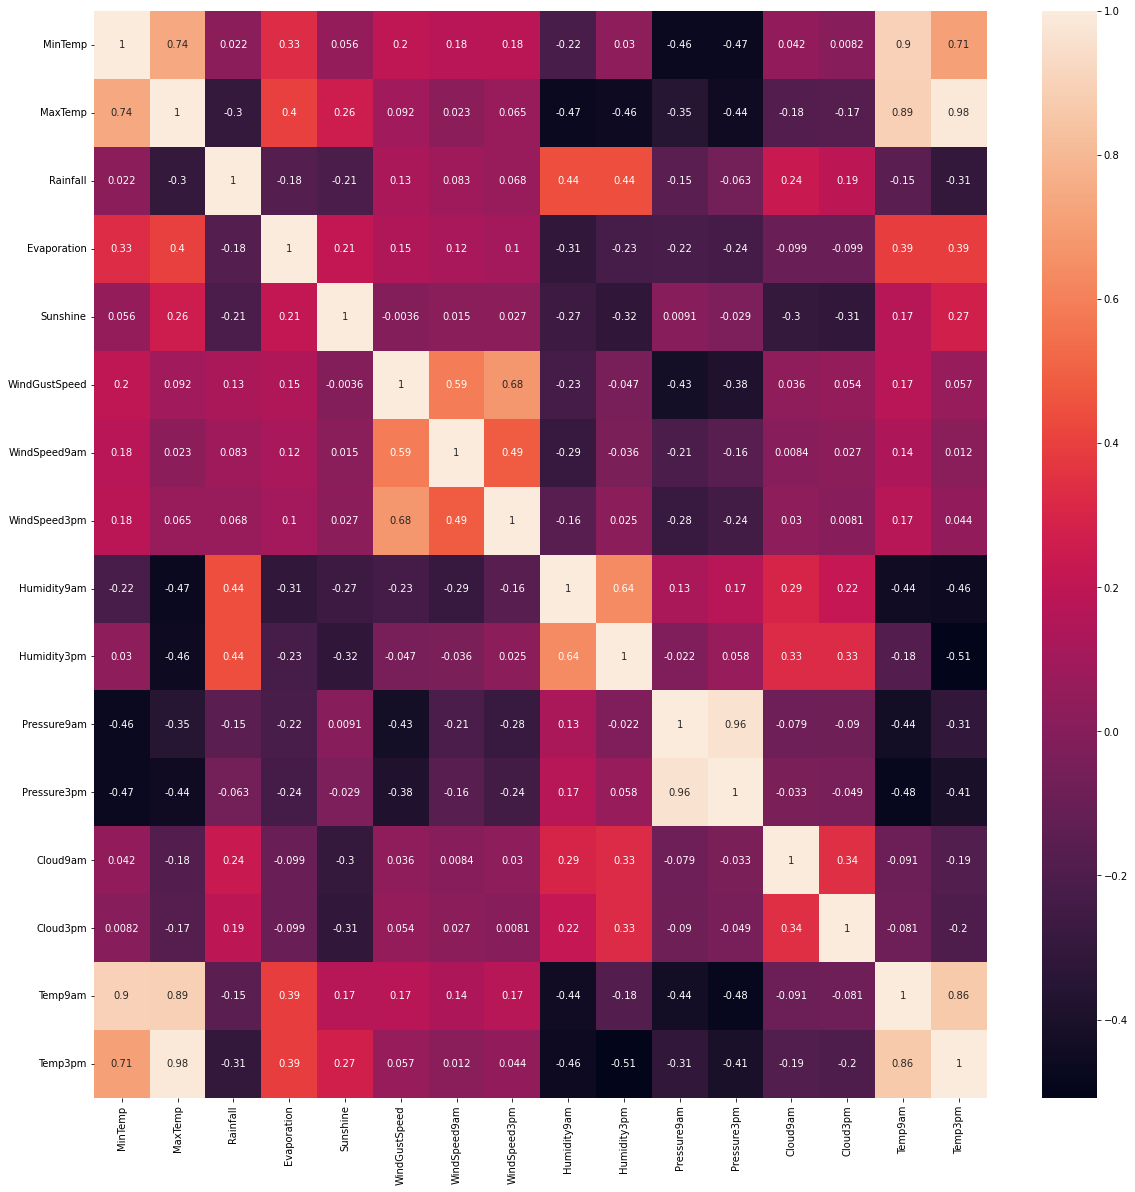

In [9]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


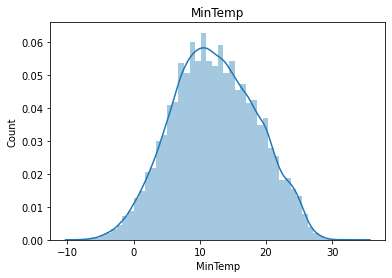

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


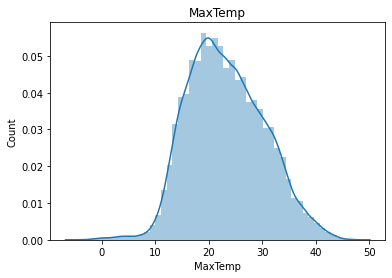

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


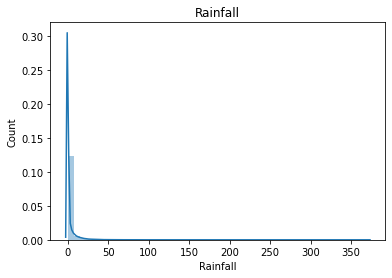

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


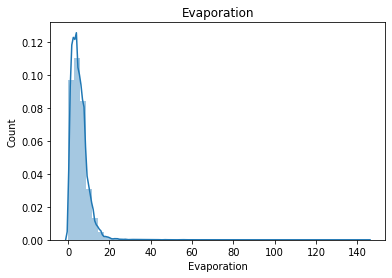

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


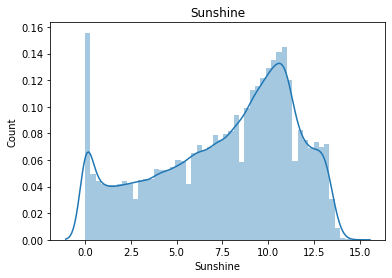

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


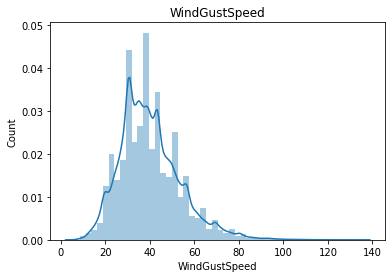

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


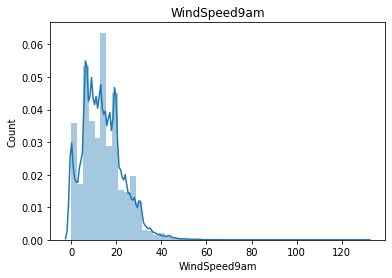

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


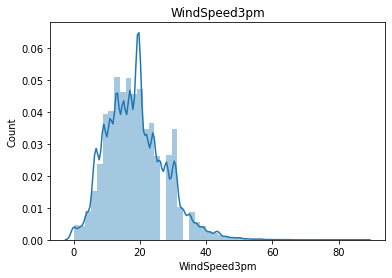

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


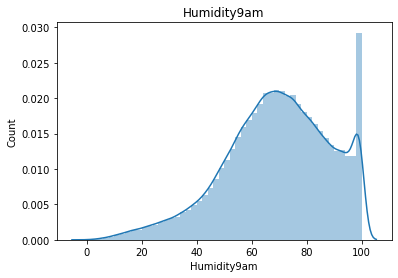

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


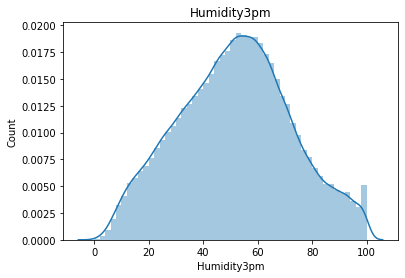

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


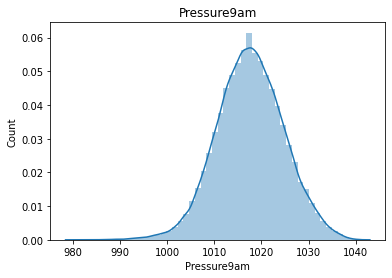

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


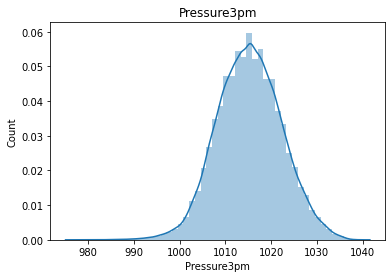

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


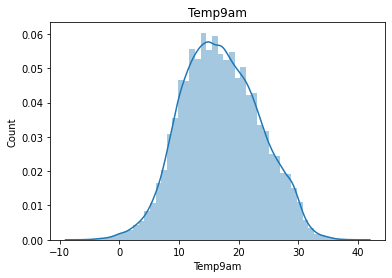

<Figure size 1080x1080 with 0 Axes>

/usr/lib/python3/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


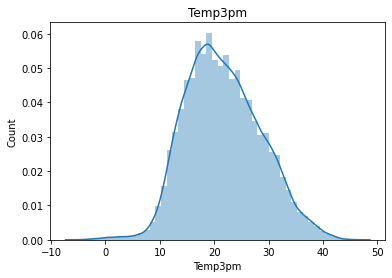

<Figure size 1080x1080 with 0 Axes>

In [10]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWar

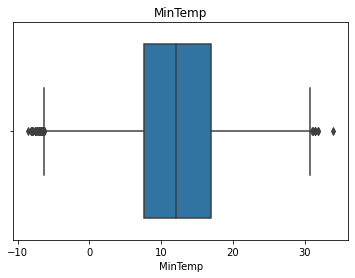

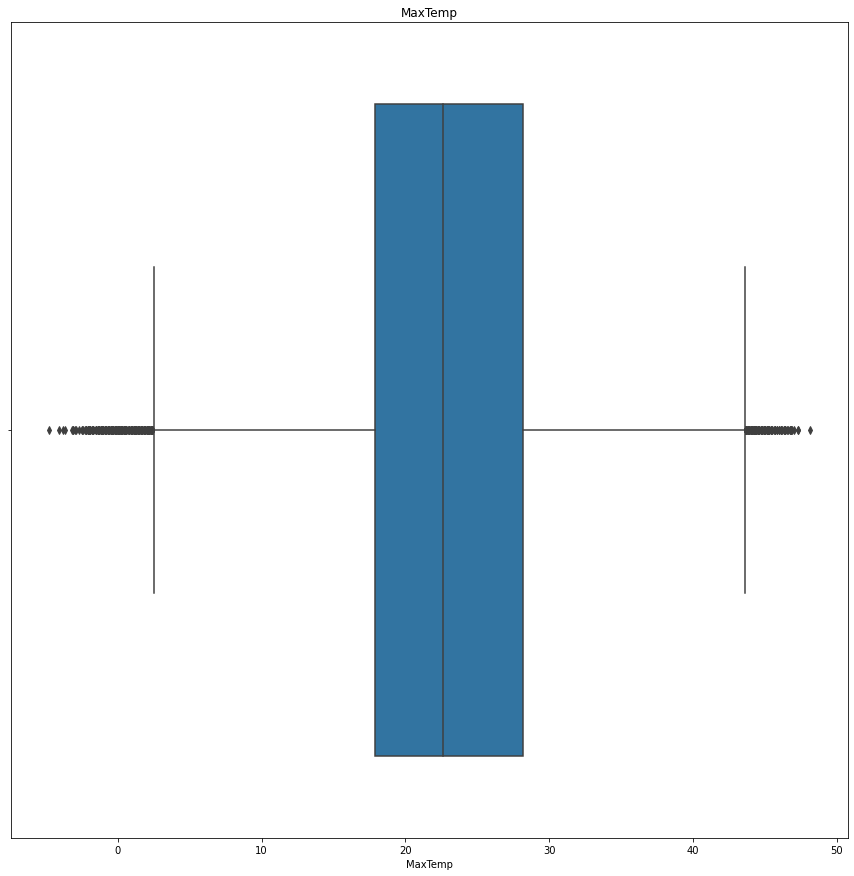

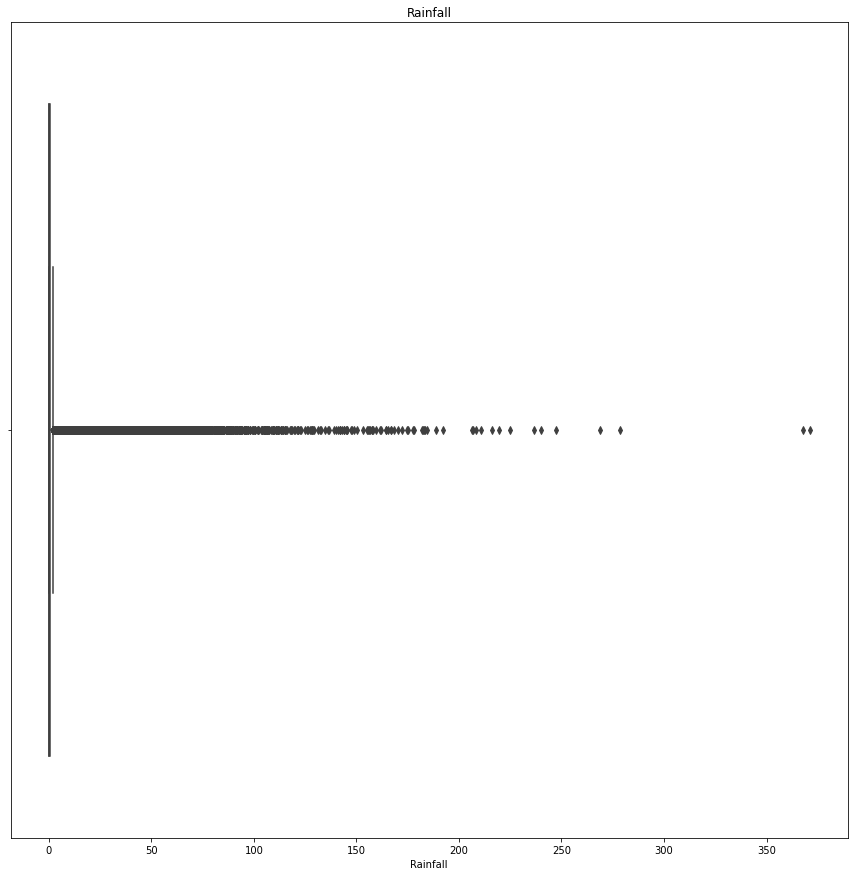

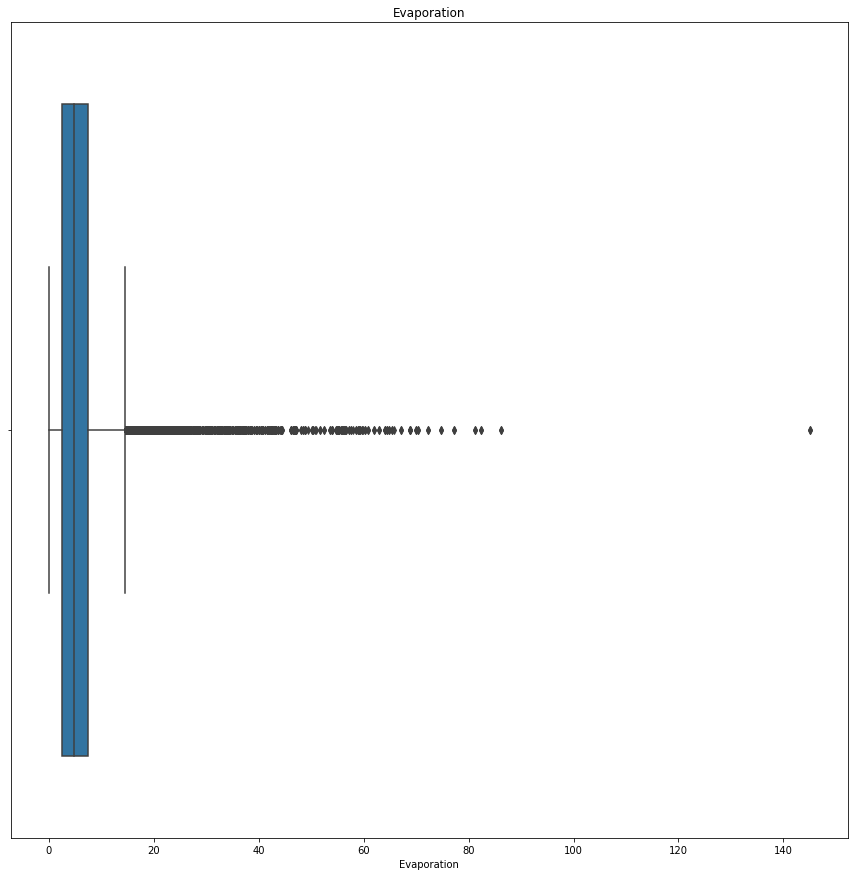

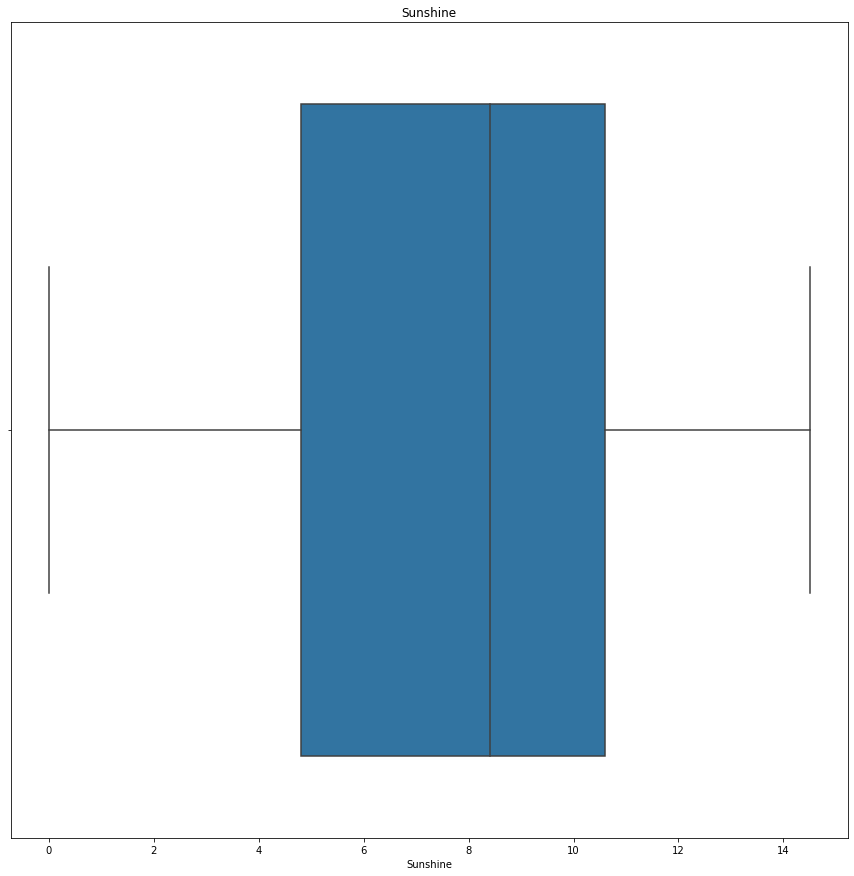

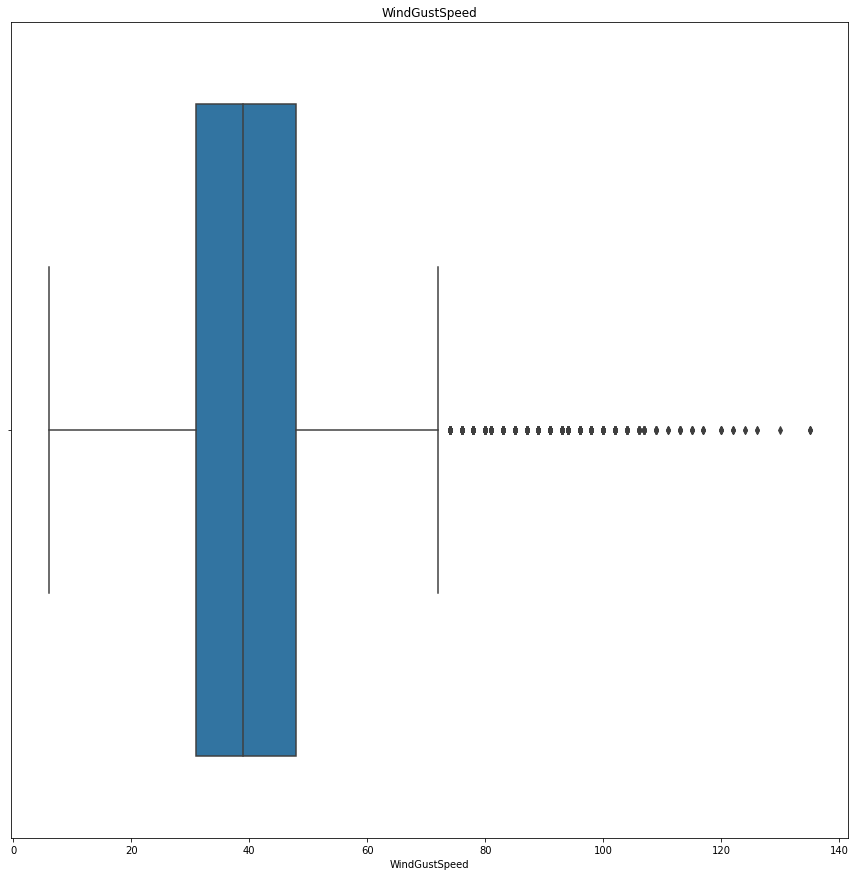

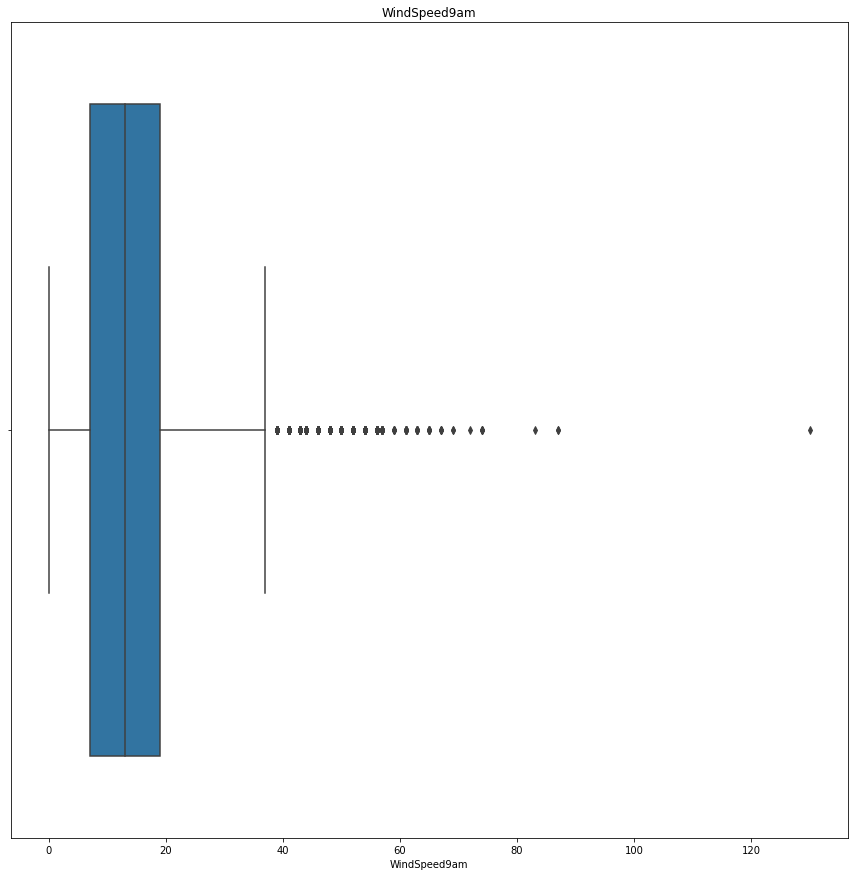

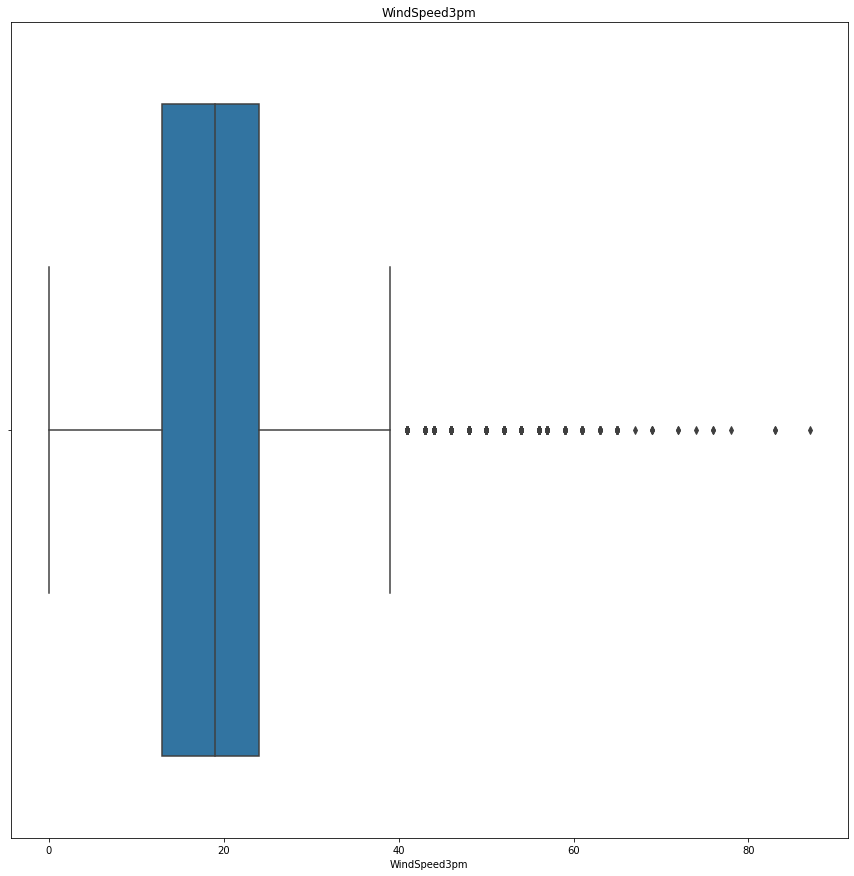

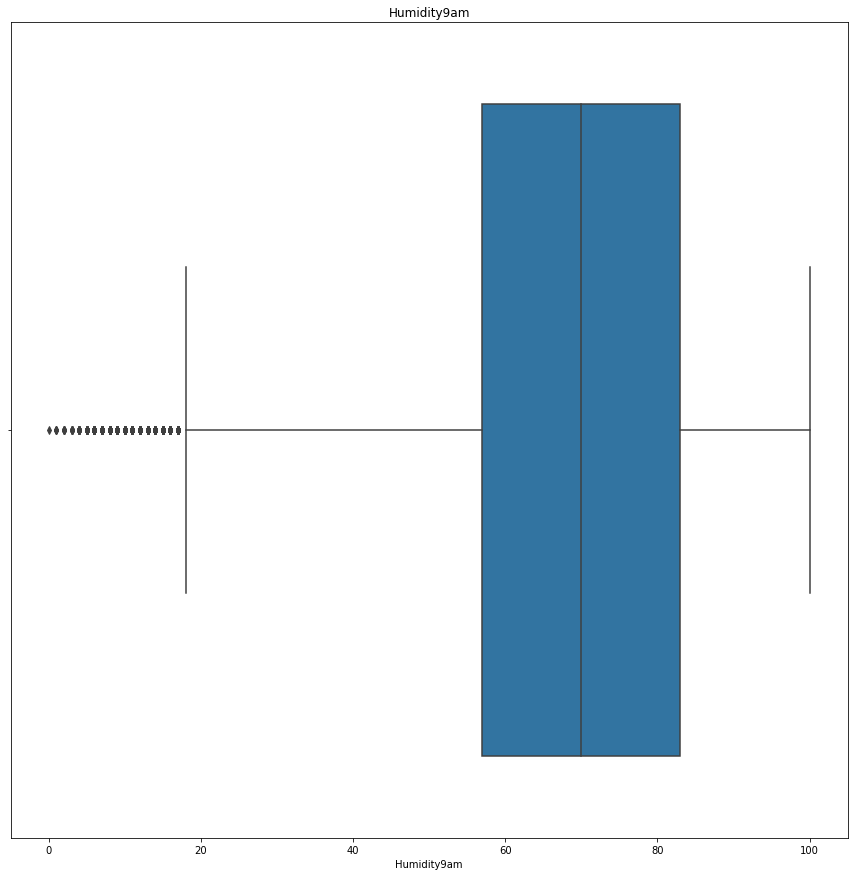

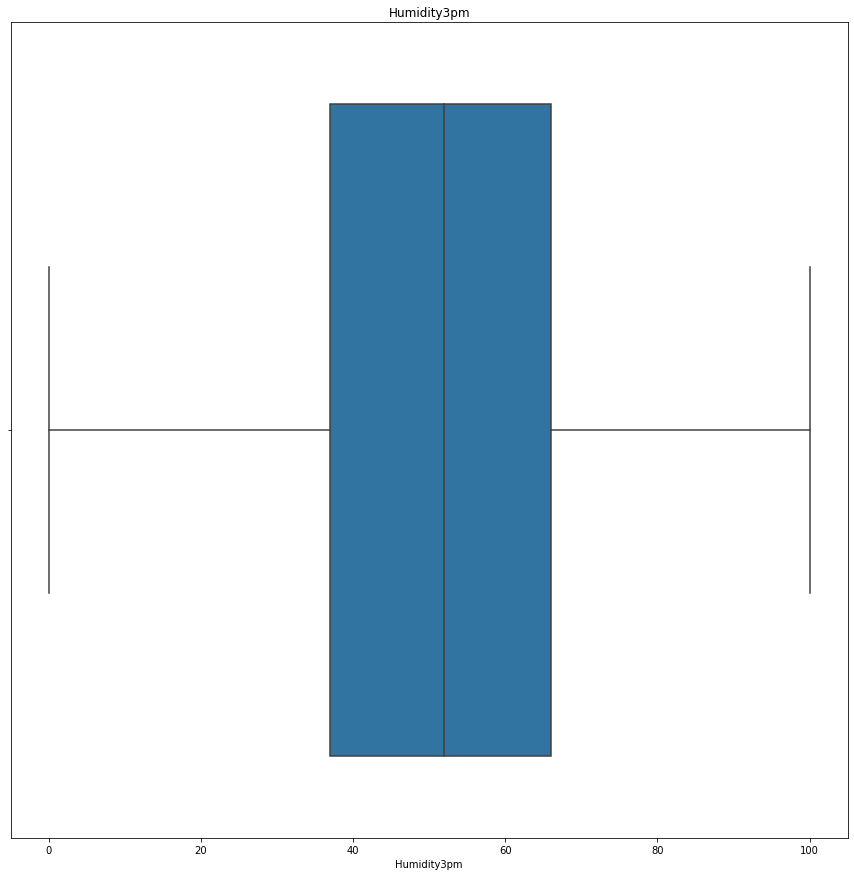

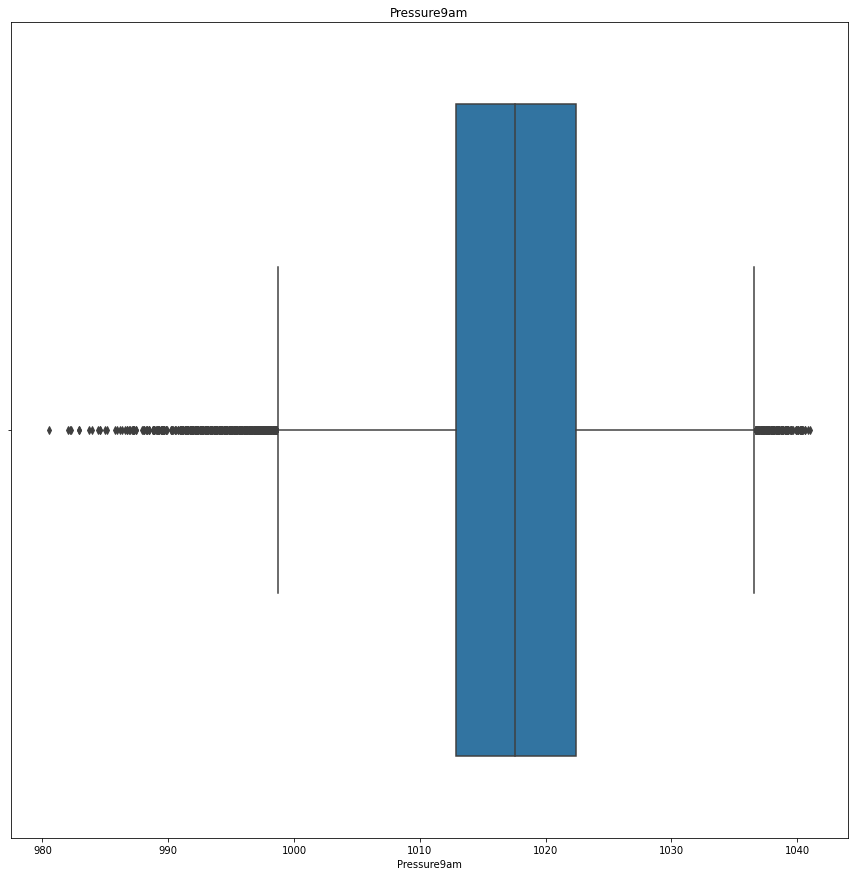

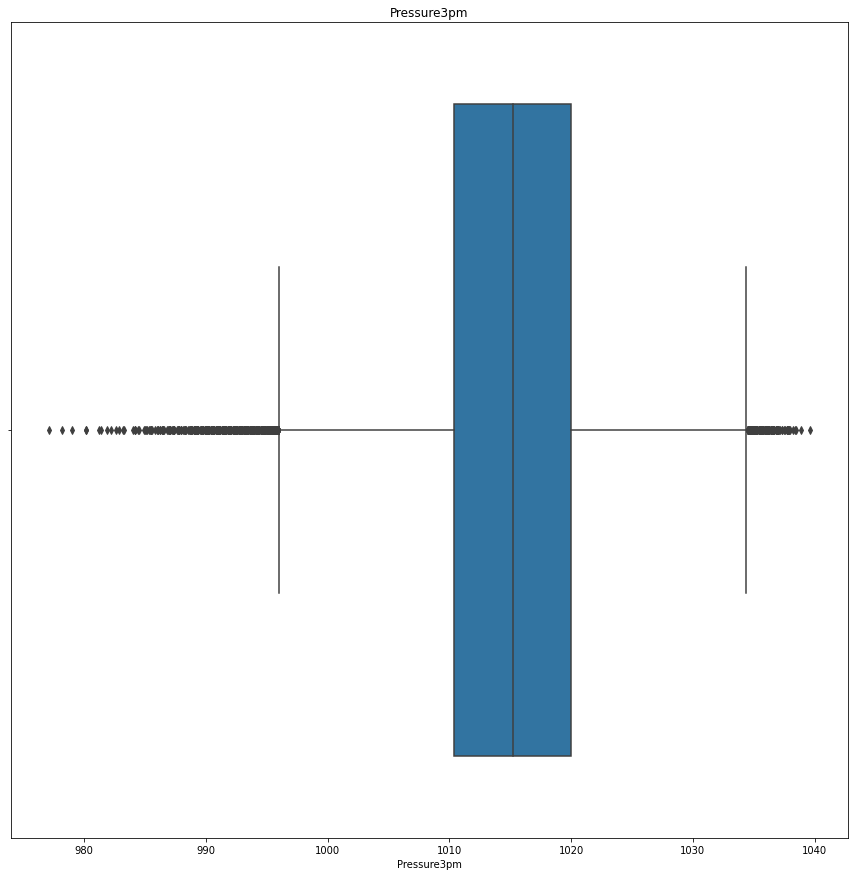

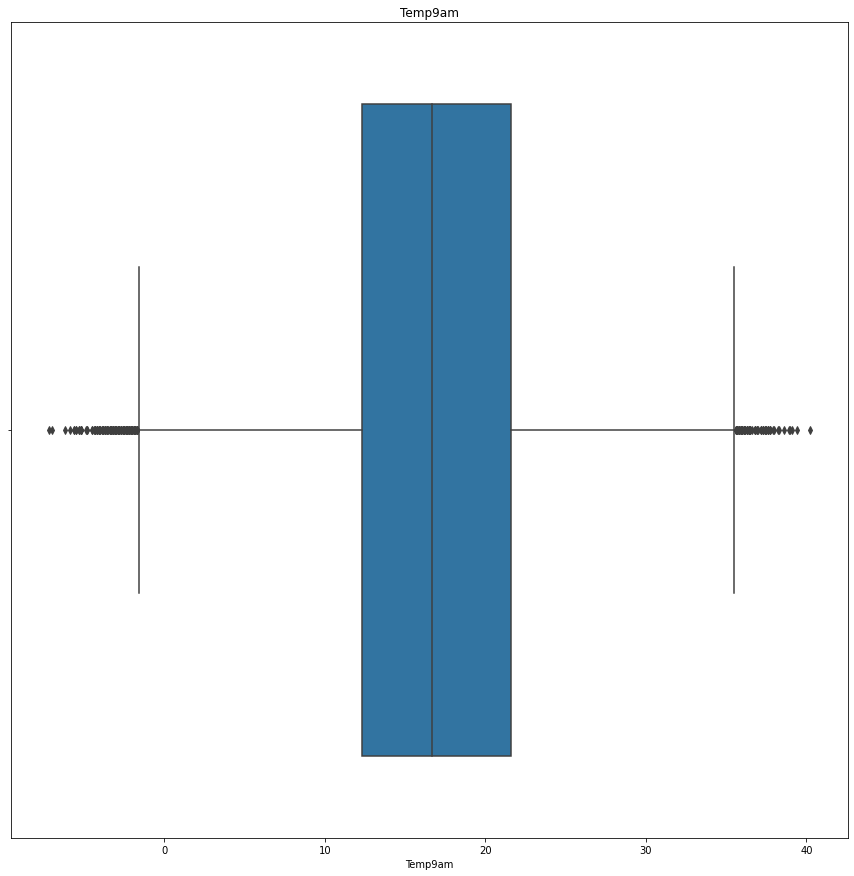

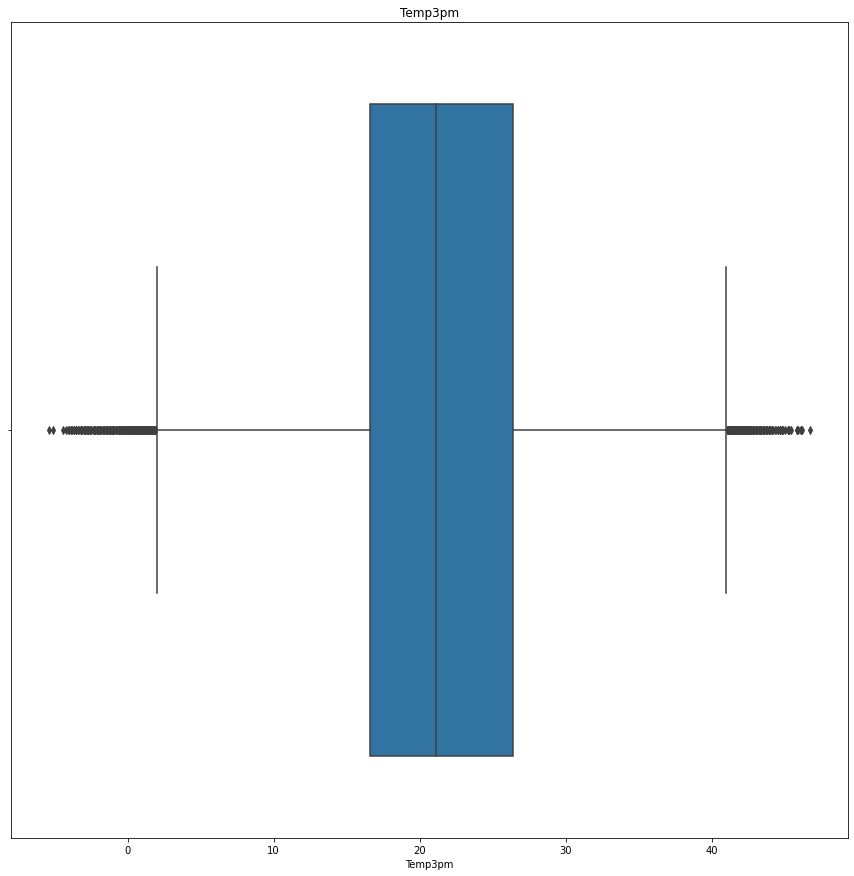

<Figure size 1080x1080 with 0 Axes>

In [11]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [12]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [13]:
df.isnull().sum()*100/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

In [14]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [15]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [16]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Ahmedabad,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,02-12-2008,Ahmedabad,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,03-12-2008,Ahmedabad,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,04-12-2008,Ahmedabad,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,05-12-2008,Ahmedabad,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Guwahati,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,22-06-2017,Guwahati,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,23-06-2017,Guwahati,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,24-06-2017,Guwahati,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [17]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['19-12-2007', '30-01-2008', '24-12-2007', '13-04-2008', '19-06-2008',
       '02-11-2007', '03-11-2007', '20-12-2007', '03-12-2007', '21-12-2007',
       ...
       '29-04-2008', '25-04-2008', '14-01-2008', '14-02-2008', '19-08-2008',
       '29-03-2008', '29-02-2008', '08-03-2008', '19-07-2008', '01-01-2008'],
      dtype='object', name='Date', length=3436)
Location Index(['Vadodara', 'Jodhpur', 'Dehradun', 'Nashik', 'Shillong', 'Gurugram',
       'Coimbature', 'Mysore', 'Nagpur', 'Puducherry', 'Patna', 'Srinagar',
       'Leh', 'Jaisalmar', 'Kanpur', 'Newdelhi', 'Salem', 'Madhurai', 'Bhopal',
       'Valparai', 'Surat', 'Kochi', 'Shimla', 'Durgapur', 'Gaya', 'Mangalore',
       'Kollam', 'Pune', 'Bengaluru', 'Ludhiana', 'Ahmedabad',
       'Tiruvanantapuram', 'Ranchi', 'Jaipur', 'Agra', 'Vishakapatnam',
       'Udaipur', 'Kozhikode', 'Bhubaneshwar', 'Mumbai', 'Chennai', 'Kolkatta',
       'Varanasi', 'Guwahati', 'Indore', '6', '29-12-2011'],
      dtype='object', name='Lo

In [18]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [19]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [20]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [21]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

In [22]:
df1

RainTomorrow,0,1
Location,,
29-12-2011,1.0,NaN
6,1.0,NaN
Agra,2807.0,629.0
Ahmedabad,4943.0,1137.0
Bengaluru,2426.0,583.0
Bhopal,2327.0,713.0
Bhubaneshwar,1336.0,242.0
Chennai,2623.0,386.0
Coimbature,2140.0,869.0


In [23]:
df1.dropna()

RainTomorrow,0,1
Location,,
Agra,2807.0,629.0
Ahmedabad,4943.0,1137.0
Bengaluru,2426.0,583.0
Bhopal,2327.0,713.0
Bhubaneshwar,1336.0,242.0
Chennai,2623.0,386.0
Coimbature,2140.0,869.0
Dehradun,2087.0,922.0
Durgapur,2366.0,643.0


In [24]:
df1[1].sort_values(ascending = False)

Location
Gurugram            1781.0
Patna               1600.0
Madhurai            1428.0
Ahmedabad           1137.0
Jodhpur              950.0
Vadodara             949.0
Dehradun             922.0
Shillong             920.0
Nashik               919.0
Coimbature           869.0
Srinagar             865.0
Puducherry           852.0
Mysore               819.0
Nagpur               808.0
Jaisalmar            781.0
Leh                  774.0
Salem                761.0
Kanpur               738.0
Newdelhi             731.0
Bhopal               713.0
Kochi                709.0
Valparai             700.0
Surat                699.0
Shimla               688.0
Gaya                 645.0
Durgapur             643.0
Mangalore            636.0
Agra                 629.0
Pune                 595.0
Kollam               592.0
Bengaluru            583.0
Tiruvanantapuram     568.0
Ludhiana             567.0
Jaipur               562.0
Ranchi               560.0
Vishakapatnam        536.0
Kozhikode          

In [25]:
df1[1].sort_values(ascending = False).index

Index(['Gurugram', 'Patna', 'Madhurai', 'Ahmedabad', 'Jodhpur', 'Vadodara',
       'Dehradun', 'Shillong', 'Nashik', 'Coimbature', 'Srinagar',
       'Puducherry', 'Mysore', 'Nagpur', 'Jaisalmar', 'Leh', 'Salem', 'Kanpur',
       'Newdelhi', 'Bhopal', 'Kochi', 'Valparai', 'Surat', 'Shimla', 'Gaya',
       'Durgapur', 'Mangalore', 'Agra', 'Pune', 'Kollam', 'Bengaluru',
       'Tiruvanantapuram', 'Ludhiana', 'Jaipur', 'Ranchi', 'Vishakapatnam',
       'Kozhikode', 'Mumbai', 'Chennai', 'Kolkatta', 'Udaipur', 'Varanasi',
       'Bhubaneshwar', 'Indore', 'Guwahati', '29-12-2011', '6'],
      dtype='object', name='Location')

In [26]:
df1[1].dropna()

Location
Agra                 629.0
Ahmedabad           1137.0
Bengaluru            583.0
Bhopal               713.0
Bhubaneshwar         242.0
Chennai              386.0
Coimbature           869.0
Dehradun             922.0
Durgapur             643.0
Gaya                 645.0
Gurugram            1781.0
Guwahati             116.0
Indore               202.0
Jaipur               562.0
Jaisalmar            781.0
Jodhpur              950.0
Kanpur               738.0
Kochi                709.0
Kolkatta             327.0
Kollam               592.0
Kozhikode            472.0
Leh                  774.0
Ludhiana             567.0
Madhurai            1428.0
Mangalore            636.0
Mumbai               394.0
Mysore               819.0
Nagpur               808.0
Nashik               919.0
Newdelhi             731.0
Patna               1600.0
Puducherry           852.0
Pune                 595.0
Ranchi               560.0
Salem                761.0
Shillong             920.0
Shimla             

In [27]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Ahmedabad,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,02-12-2008,Ahmedabad,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,03-12-2008,Ahmedabad,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,04-12-2008,Ahmedabad,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,05-12-2008,Ahmedabad,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Guwahati,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,22-06-2017,Guwahati,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,23-06-2017,Guwahati,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,24-06-2017,Guwahati,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [28]:
len(df1[1].sort_values(ascending = False).index)

47

In [29]:
location = {'Gurugram':1, 'Patna':2, 'Madhurai':3, 'Ahmedabad':4, 'Jodhpur':5,
       'Vadodara':6, 'Dehradun':7, 'Shillong':8, 'Nashik':9, 'Coimbature':10,
       'Srinagar':11, 'Puducherry':12, 'Mysore':13, 'Nagpur':14, 'Jaisalmar':15,
       'Leh':16, 'salem':17, 'kanpur':18, 'Newdelhi':19, 'Bhopal':20,
       'Kochi':21, 'valparai':22, 'surat':23, 'shimla':24, 'gaya':25,
       'Durgapur':26, 'Manglore':27, 'Agra':28, 'Pune':29, 'Kollam':30, 'Bengaluru':31,
       'Tiruvanantapuram':32, 'Ludhiana':33, 'Jaipur':34, 'Ranchi':35, 'VIshakapatnam':36,
       'Kozhikode':37, 'mumbai':38, 'chennai':39, 'Kolkatta':40, 'Udaipur':41,
       'Varanasi':42, 'Bhubaneshwar':43, 'Indore':44, 'Guwahati':45,"29-12-2011":46,"6":47 }
df["Location"] = df["Location"].map(location)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,4.0,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,02-12-2008,4.0,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,03-12-2008,4.0,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,04-12-2008,4.0,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,05-12-2008,4.0,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,45.0,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,22-06-2017,45.0,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,23-06-2017,45.0,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,24-06-2017,45.0,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [30]:
df["Location"].drop(47)

0          4.0
1          4.0
2          4.0
3          4.0
4          4.0
          ... 
145455    45.0
145456    45.0
145457    45.0
145458    45.0
145459    45.0
Name: Location, Length: 145459, dtype: float64

In [31]:
df["Location"].drop(46)

0          4.0
1          4.0
2          4.0
3          4.0
4          4.0
          ... 
145455    45.0
145456    45.0
145457    45.0
145458    45.0
145459    45.0
Name: Location, Length: 145459, dtype: float64

In [32]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [33]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [34]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,NaT,4.0,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,4.0,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,4.0,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,4.0,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,4.0,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,45.0,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,45.0,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,45.0,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,45.0,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


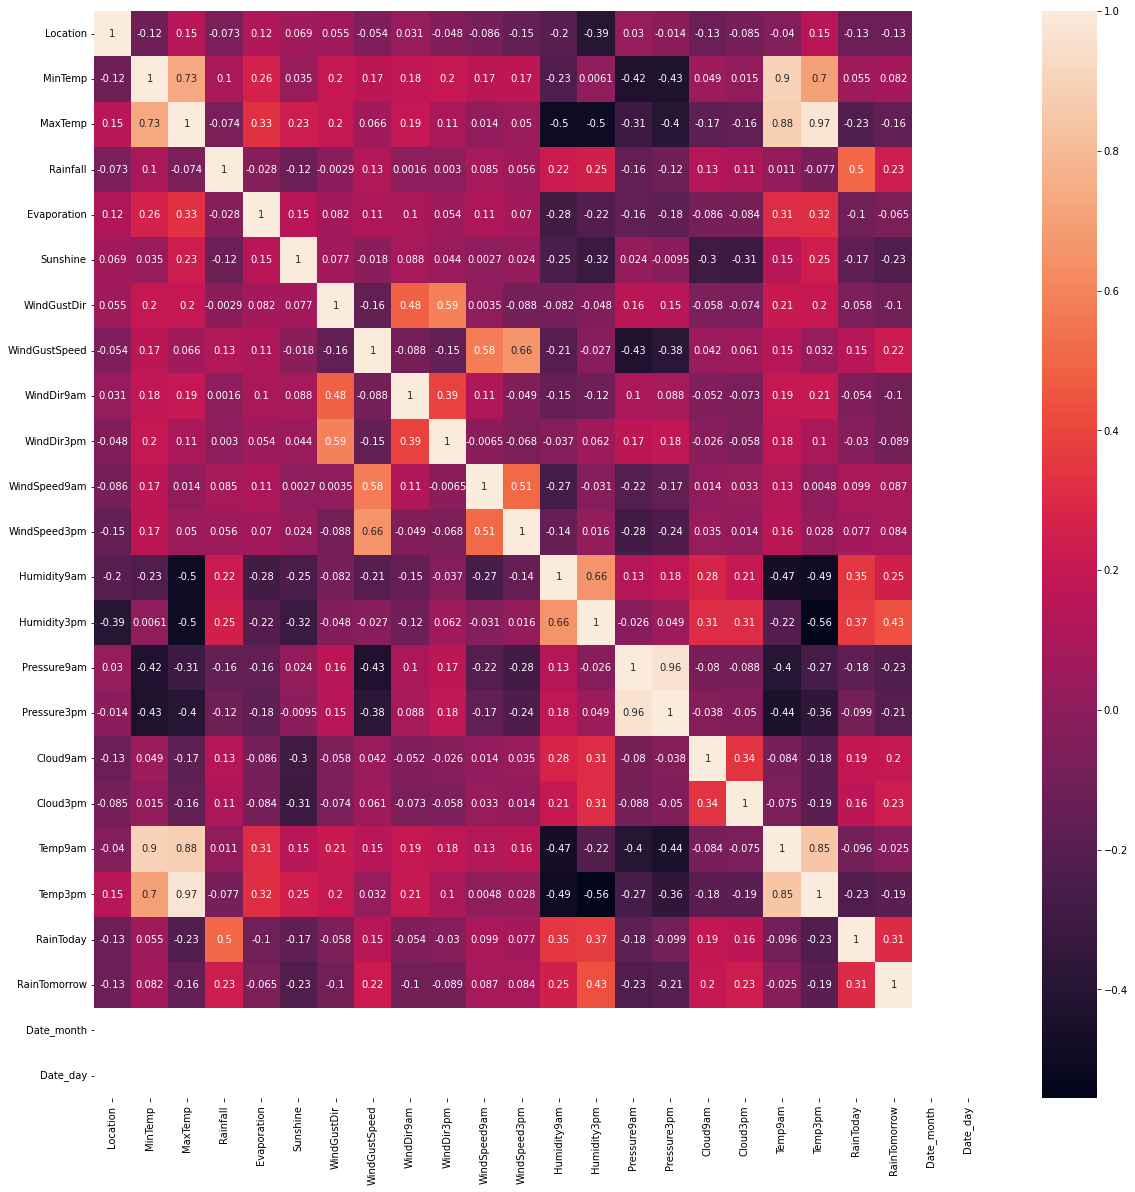

In [35]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='RainTomorrow', ylabel='count'>

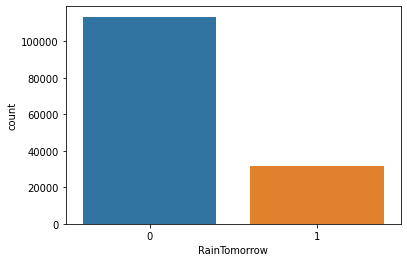

In [36]:
sns.countplot(df["RainTomorrow"])

In [37]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,NaT,4.0,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,4.0,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,4.0,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,4.0,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,4.0,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,45.0,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,45.0,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,45.0,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,45.0,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


In [38]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,NaT,4.0,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,4.0,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,4.0,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,4.0,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,4.0,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,45.0,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,45.0,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,45.0,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,45.0,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWar

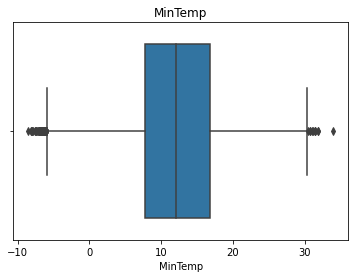

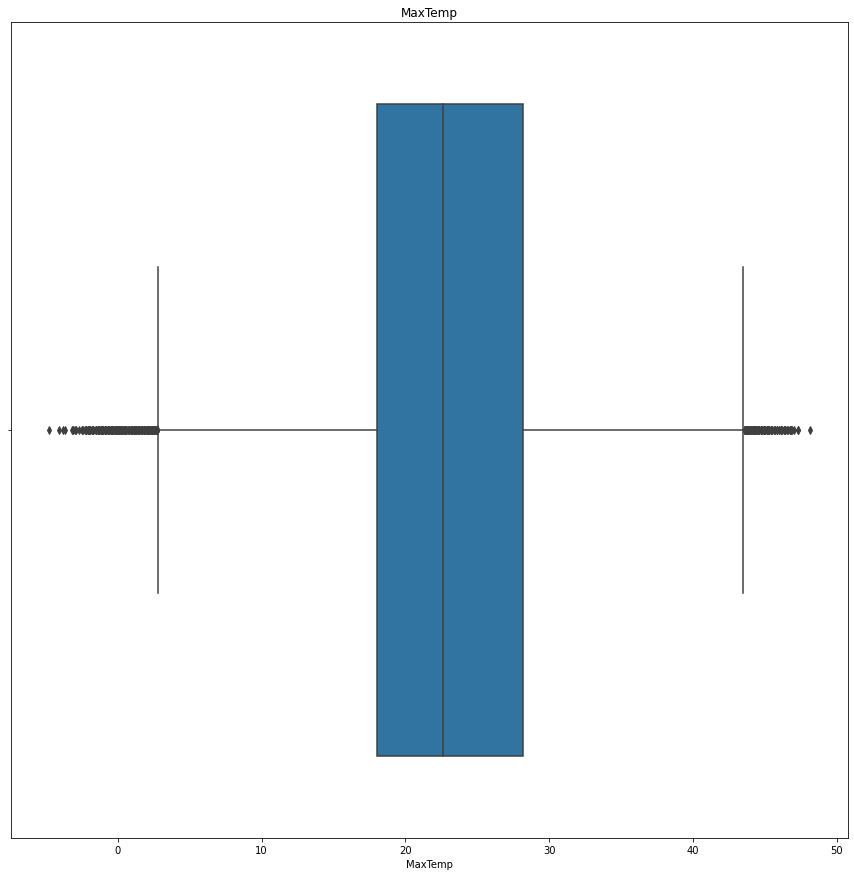

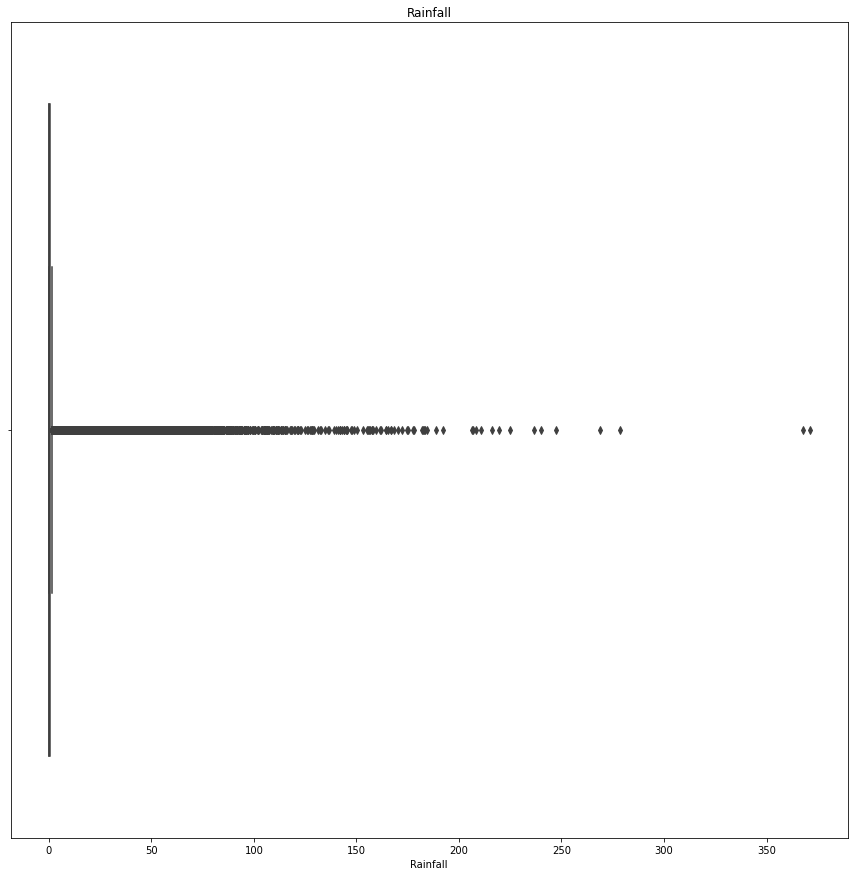

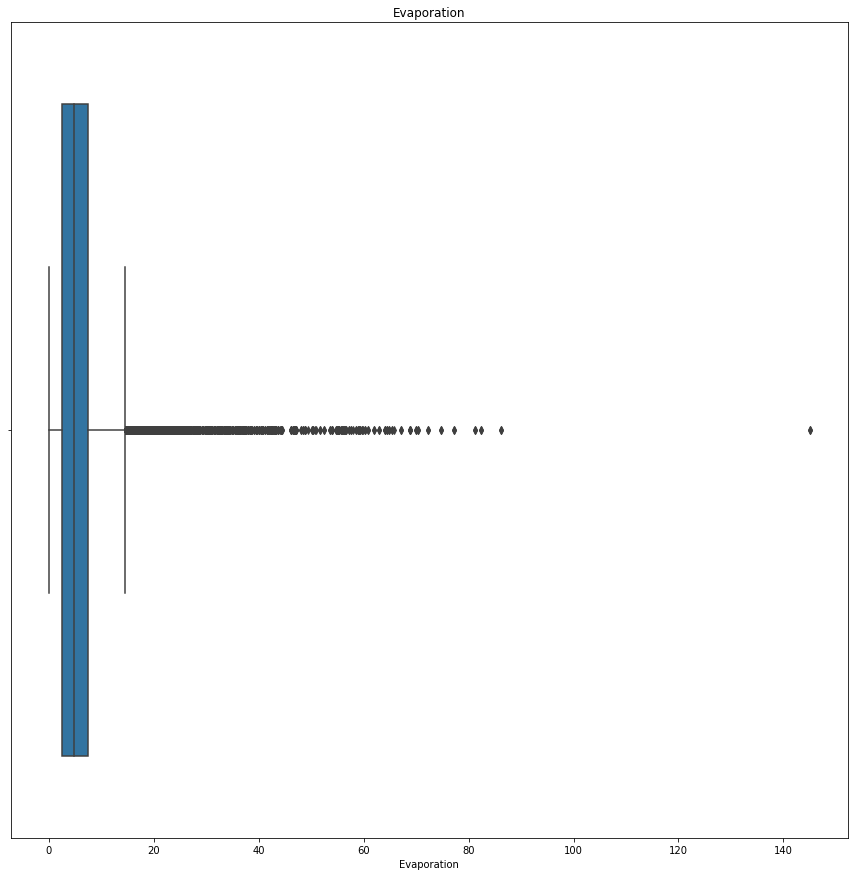

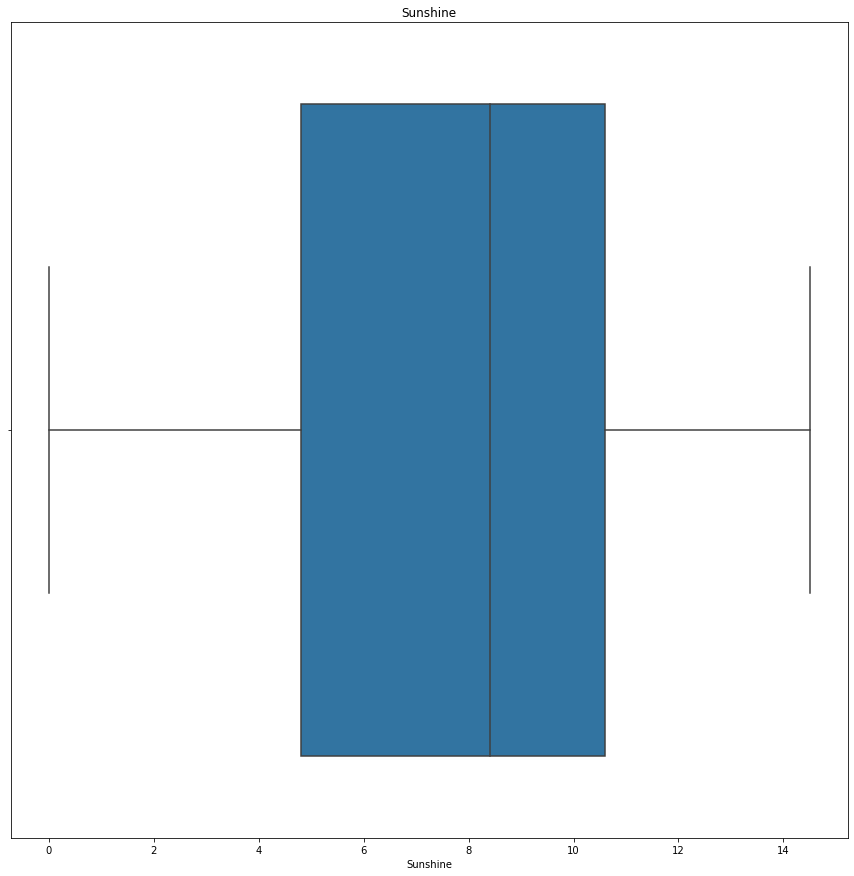

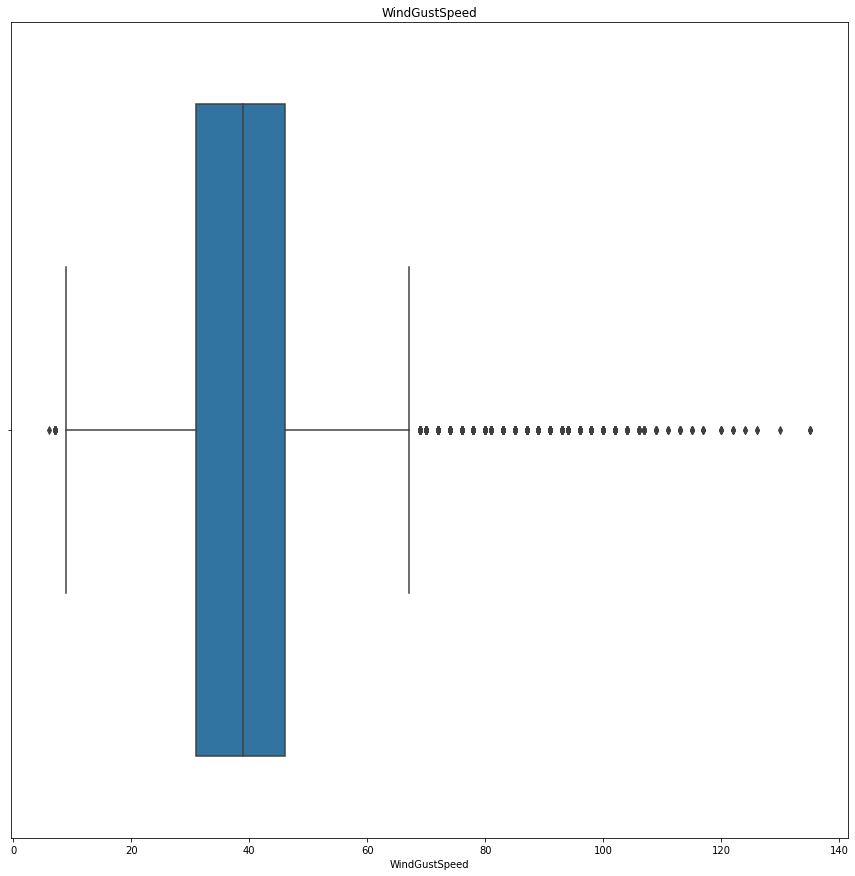

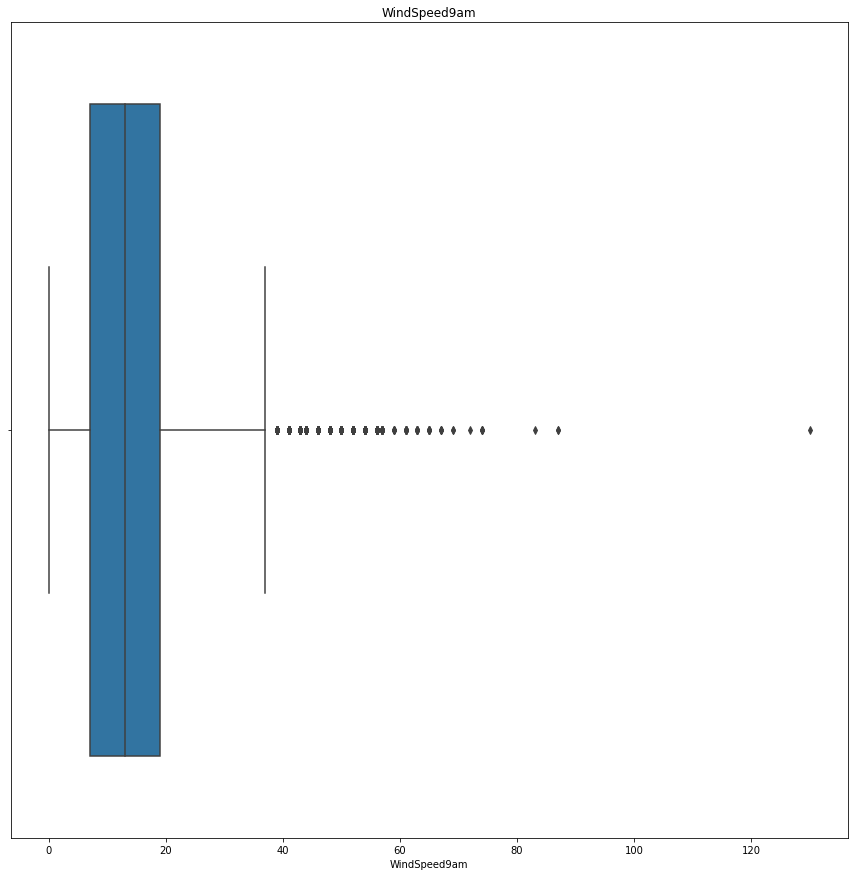

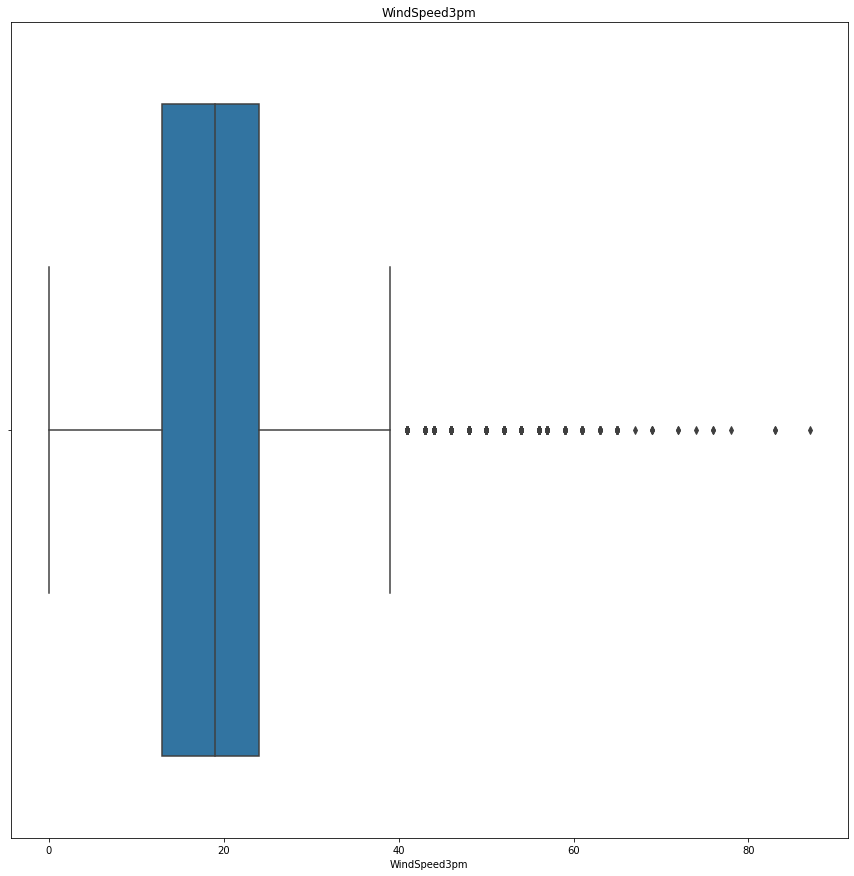

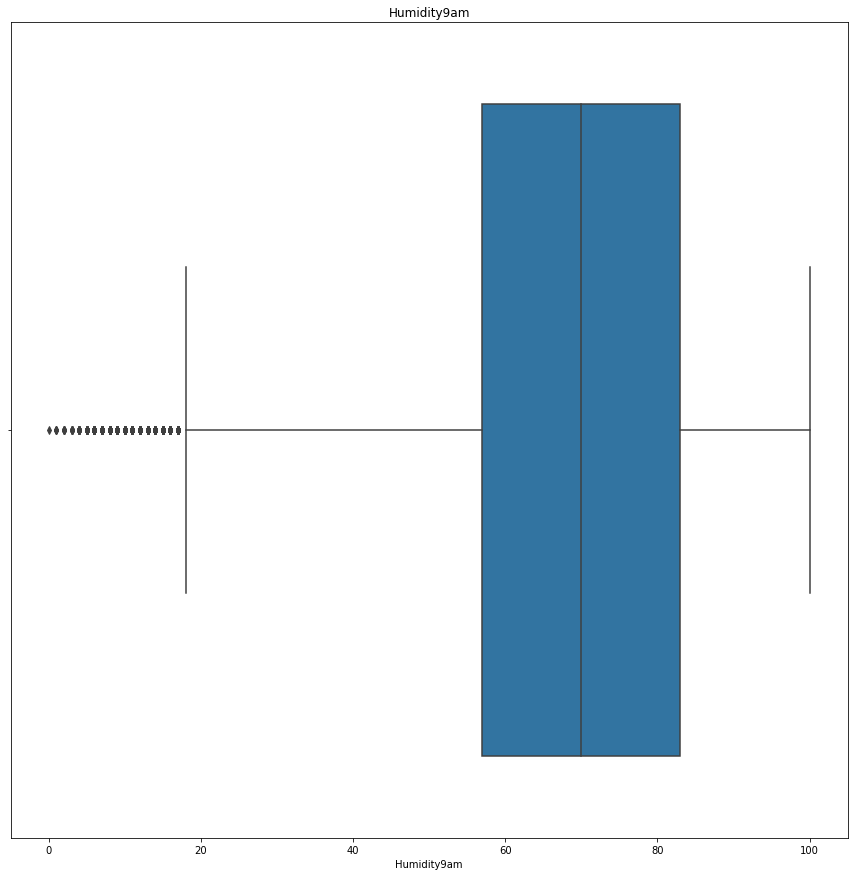

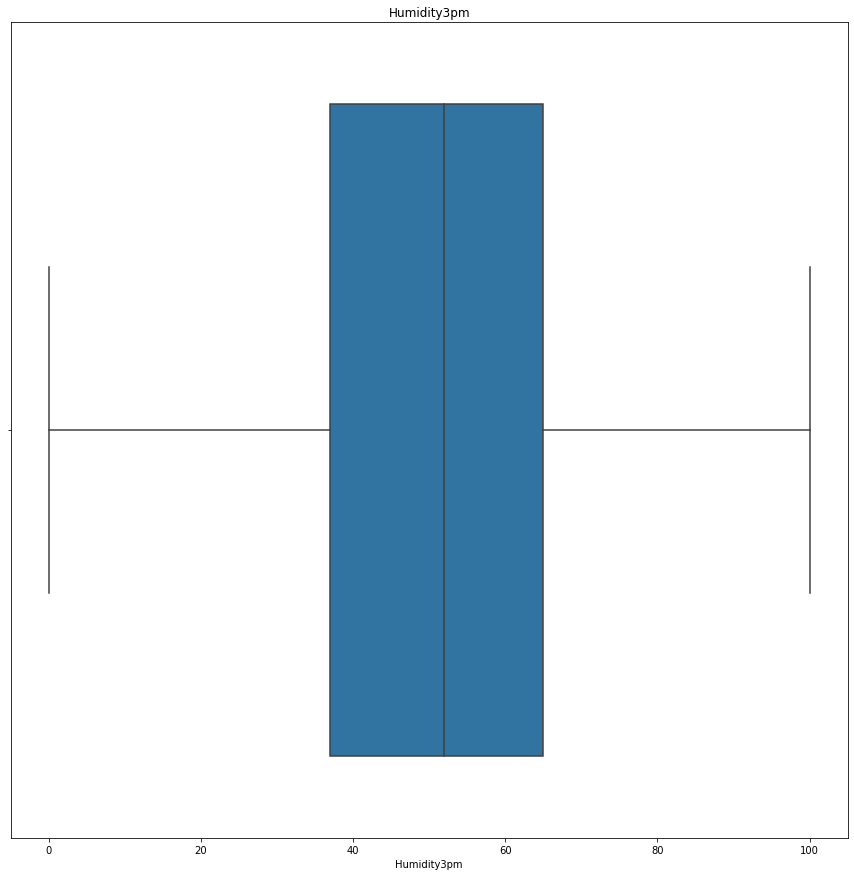

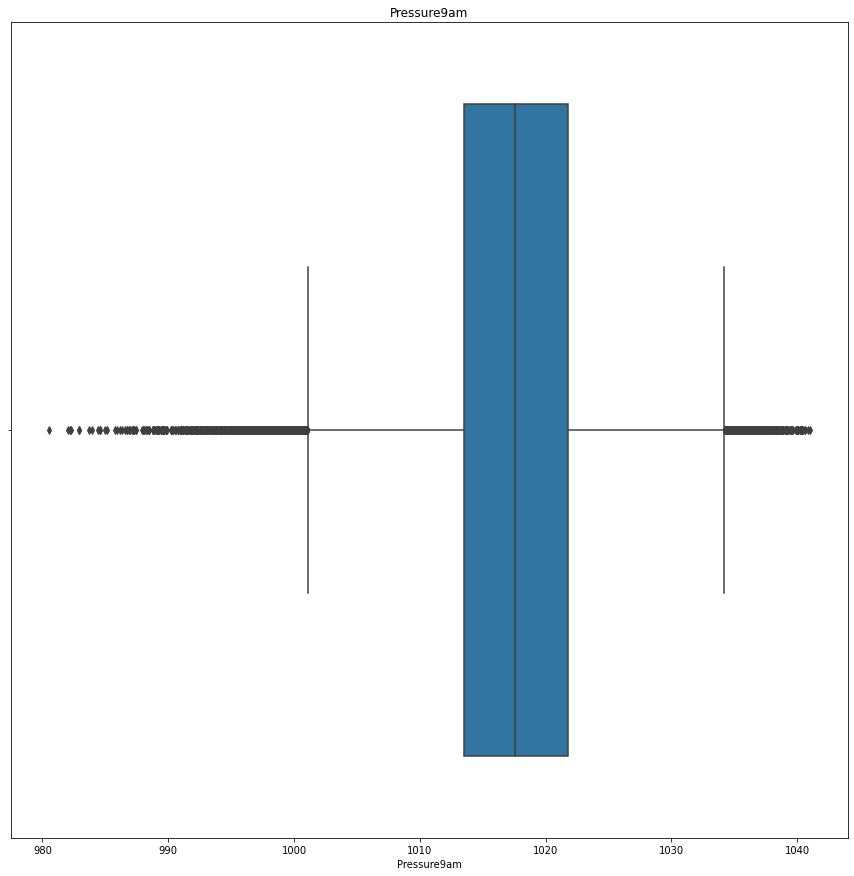

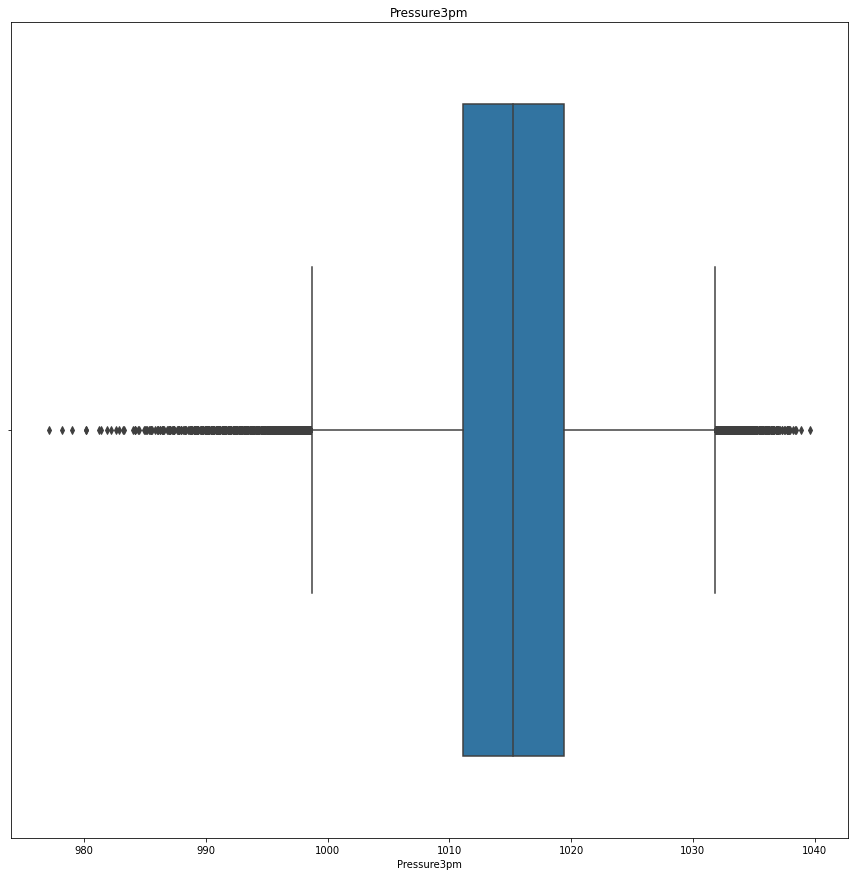

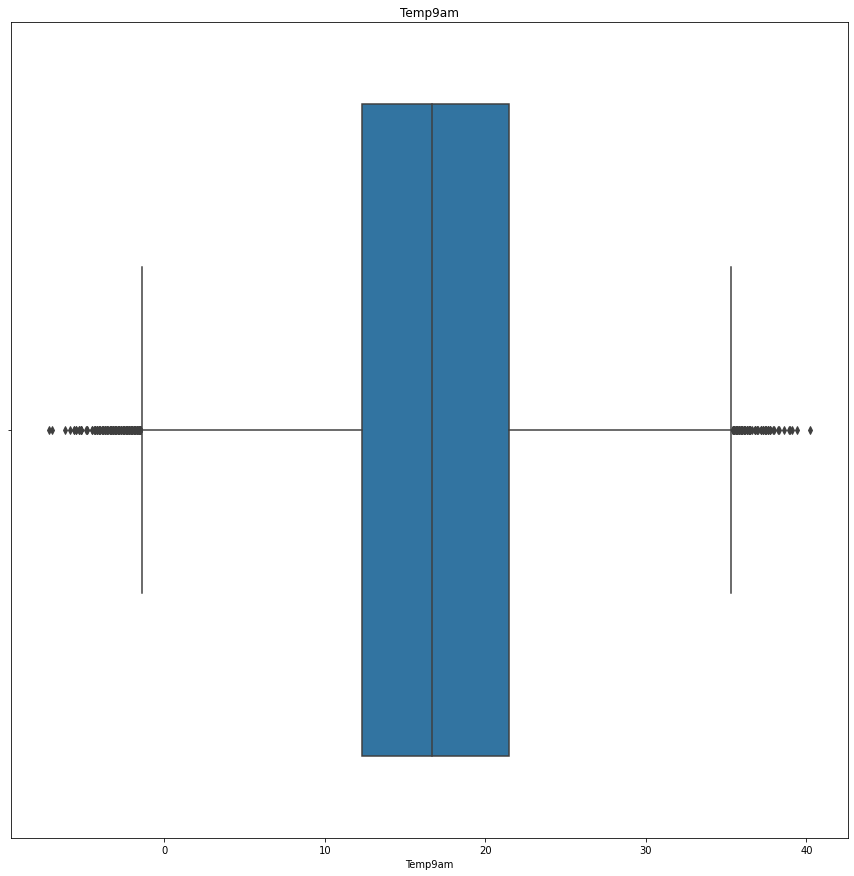

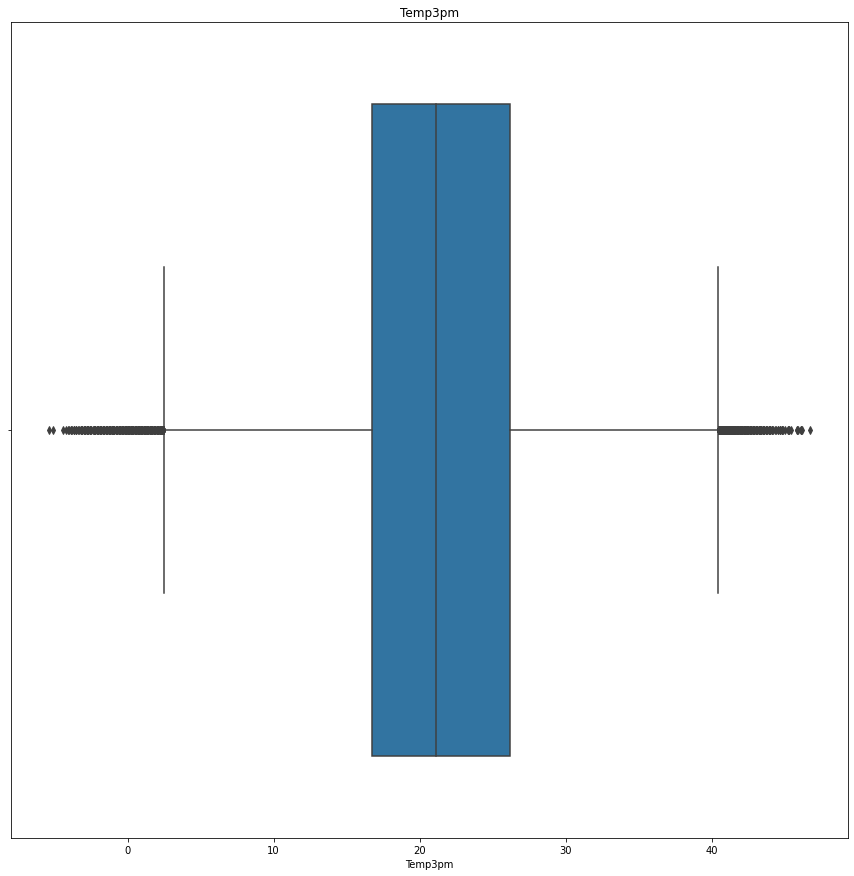

<Figure size 1080x1080 with 0 Axes>

In [39]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [40]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [41]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [42]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [43]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [44]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [45]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [46]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [47]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [48]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [49]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [50]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [51]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [52]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [53]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [54]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [55]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [56]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [57]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [58]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [59]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [60]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [61]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [62]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [63]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [64]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWar

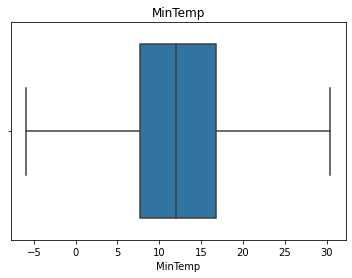

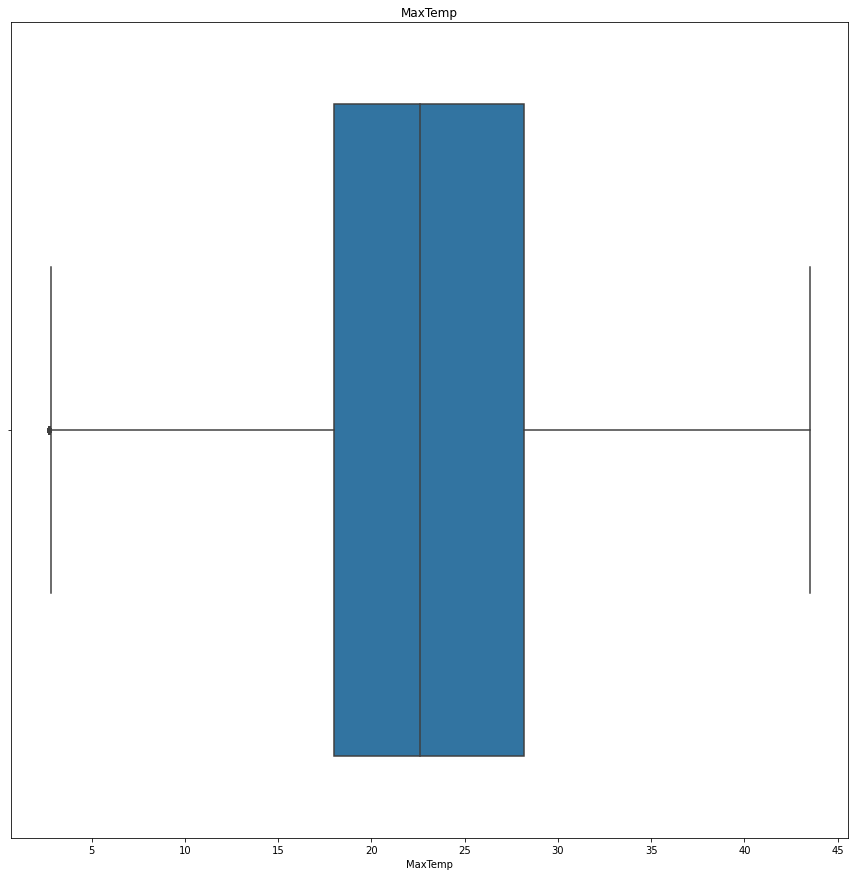

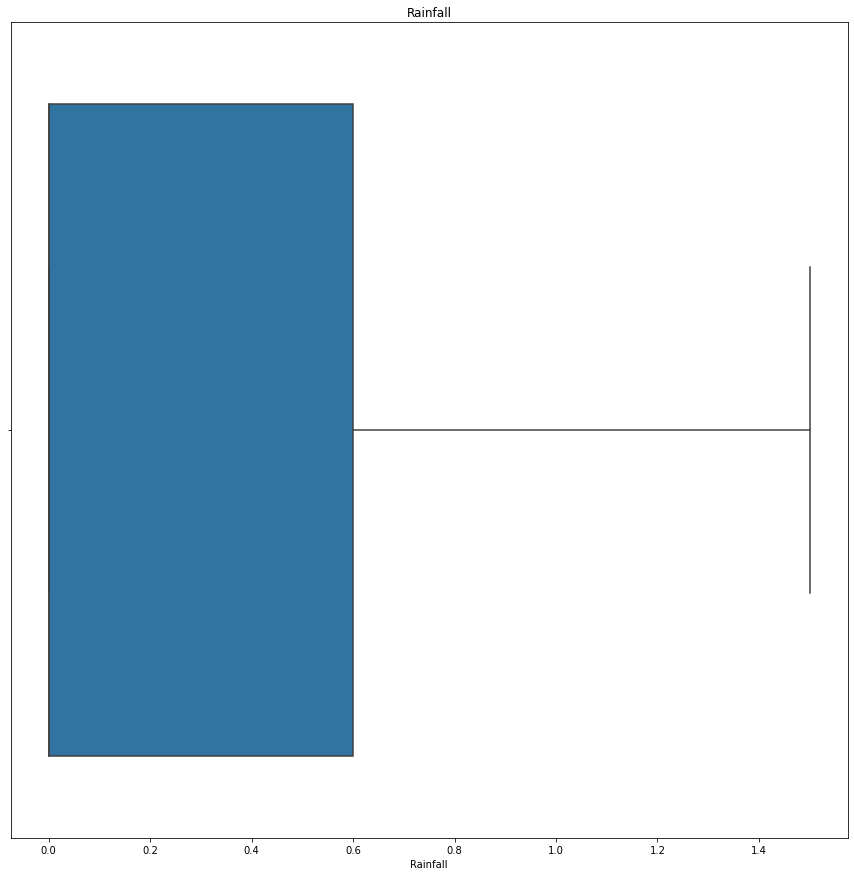

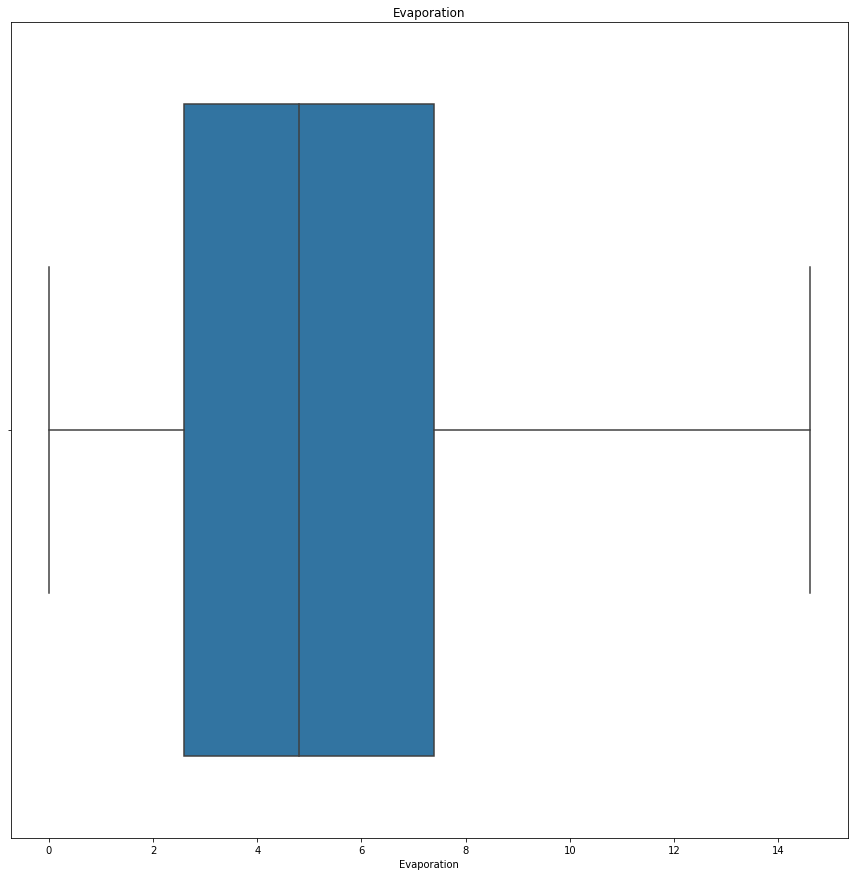

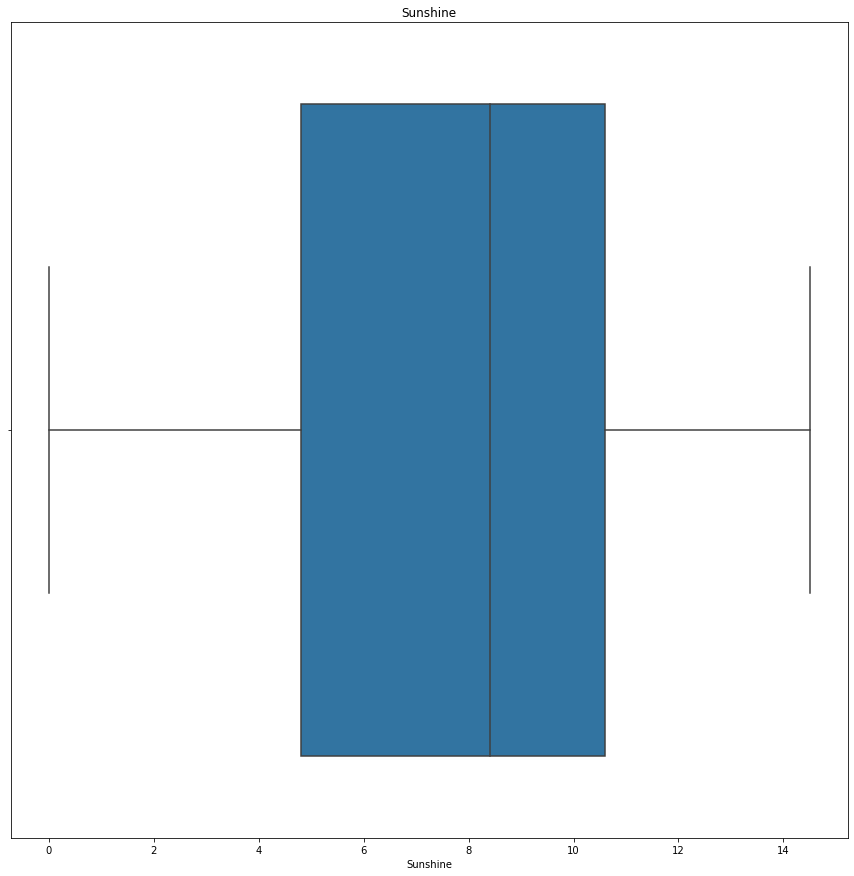

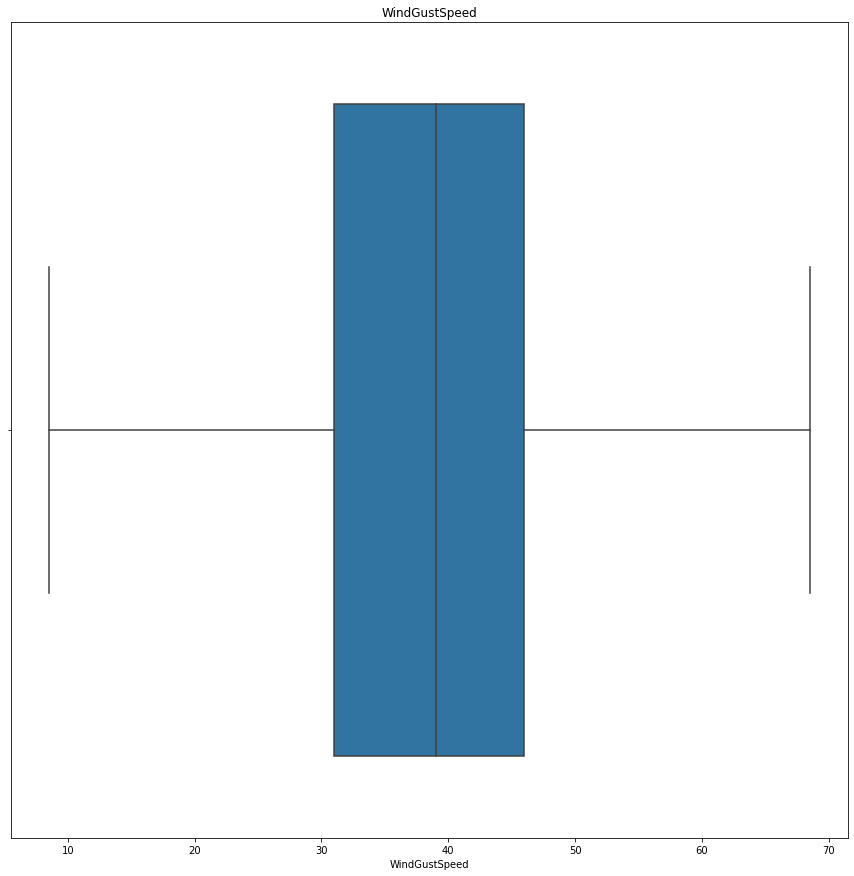

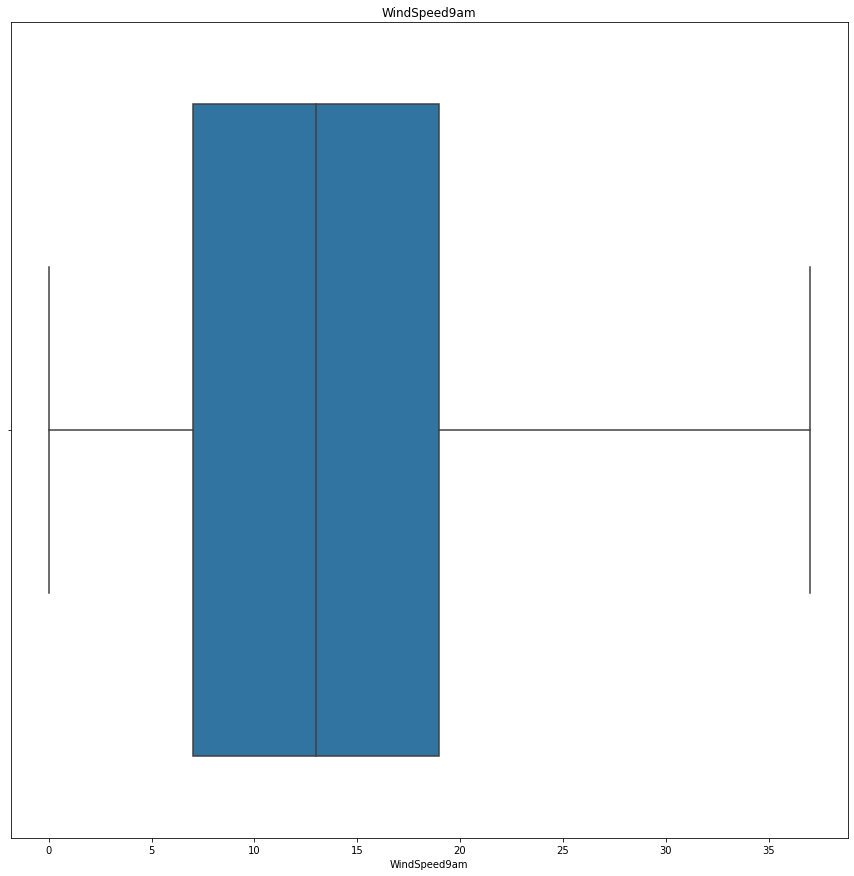

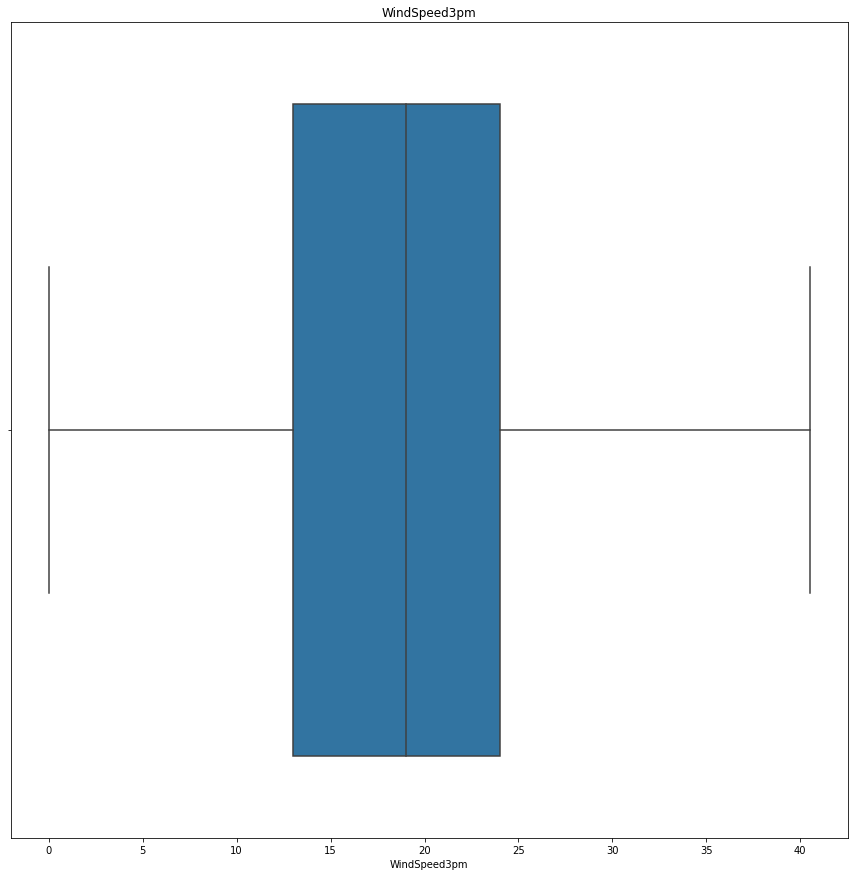

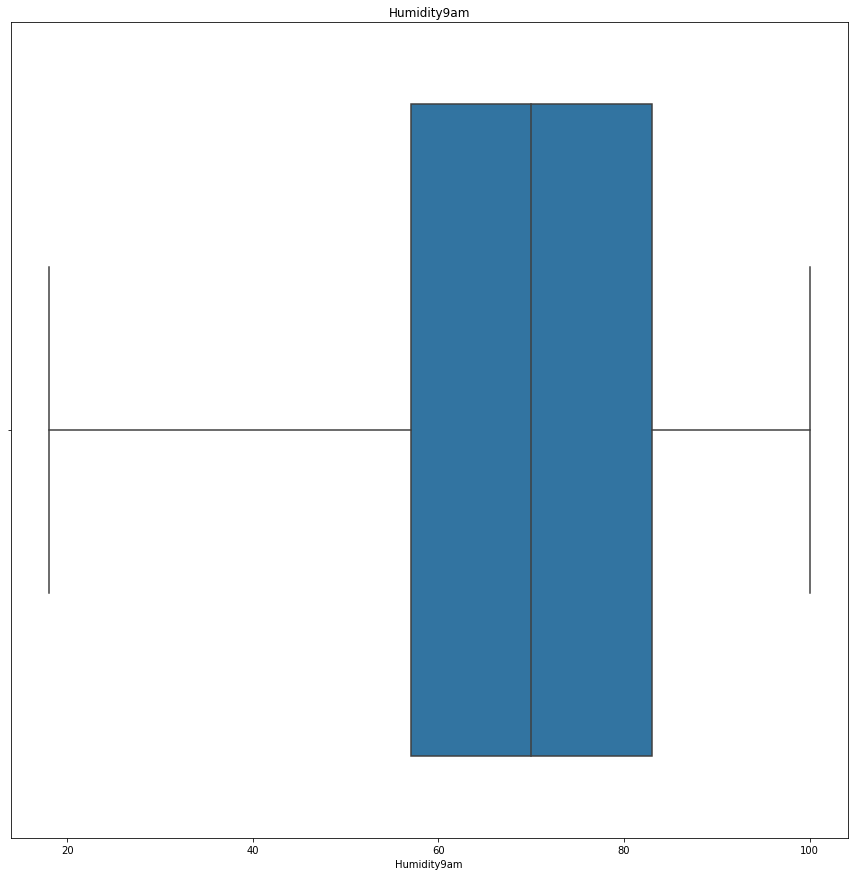

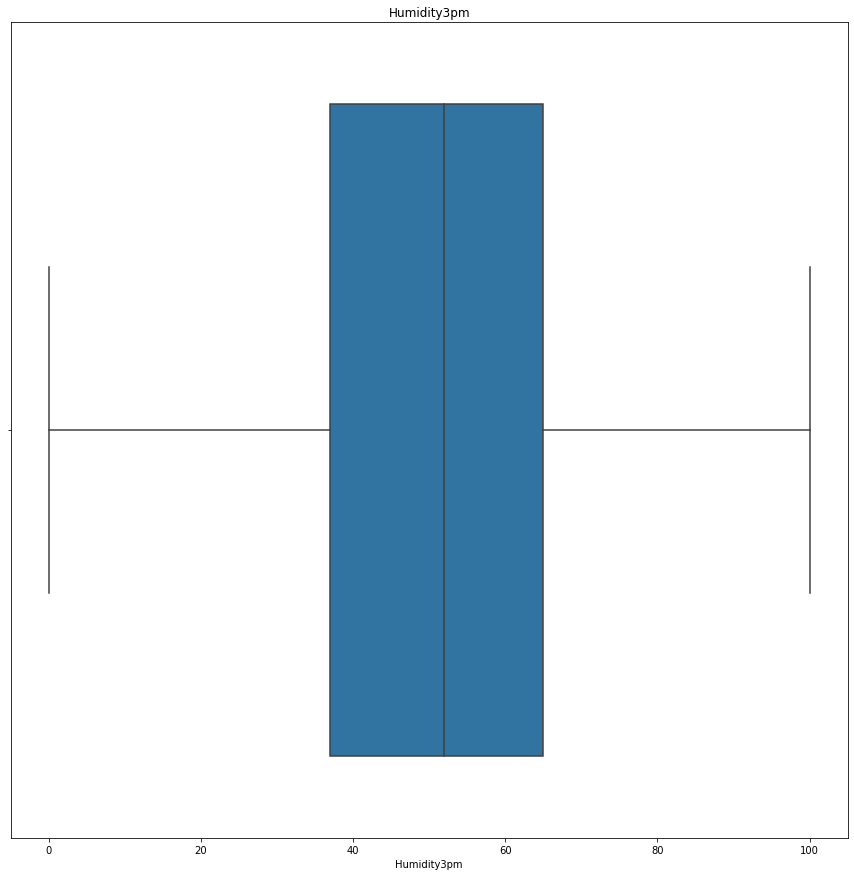

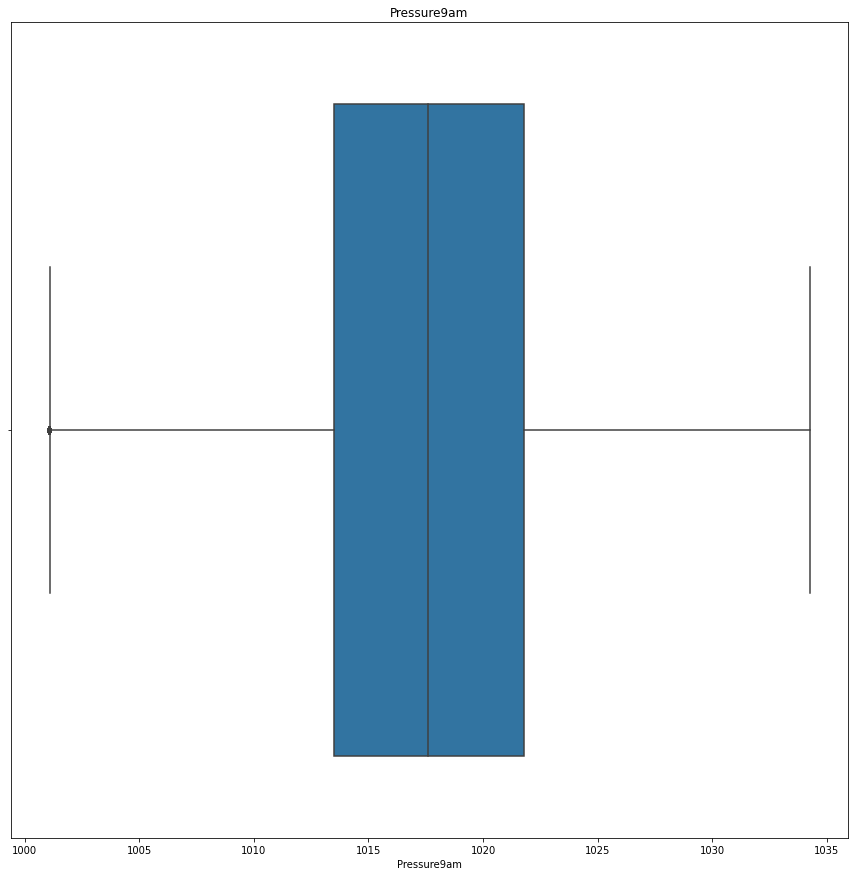

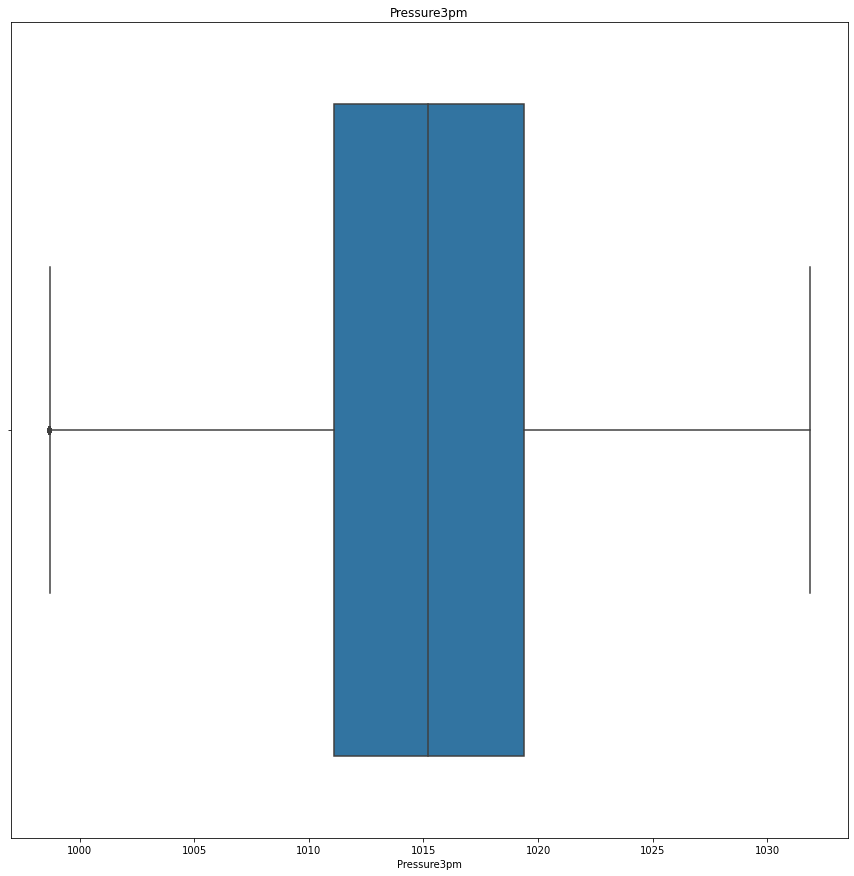

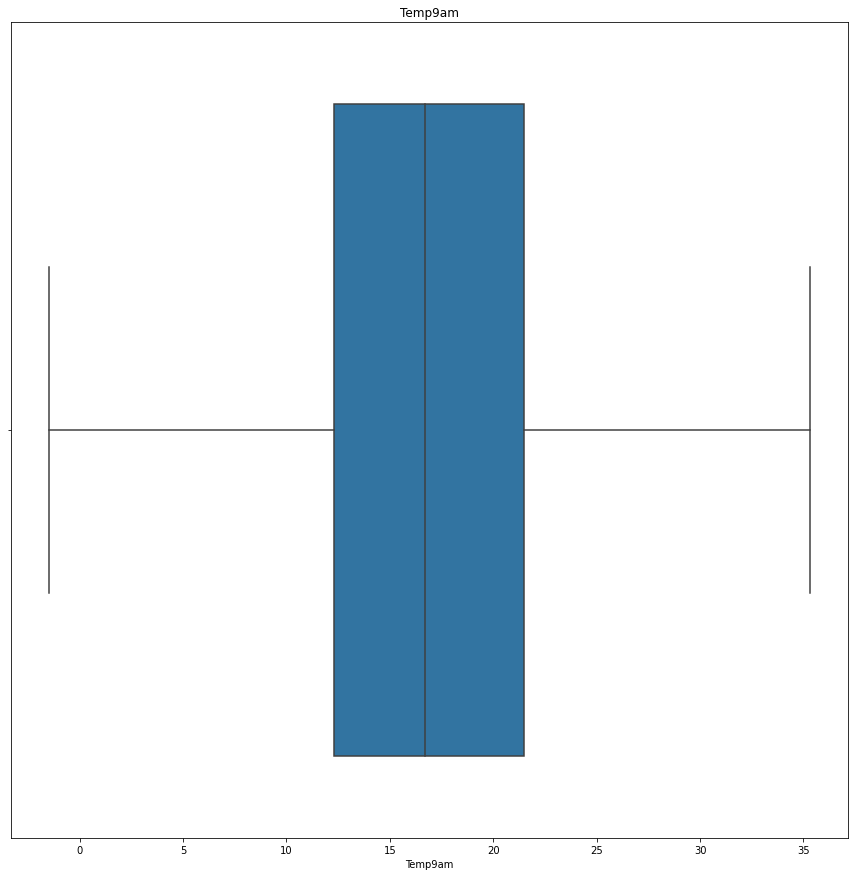

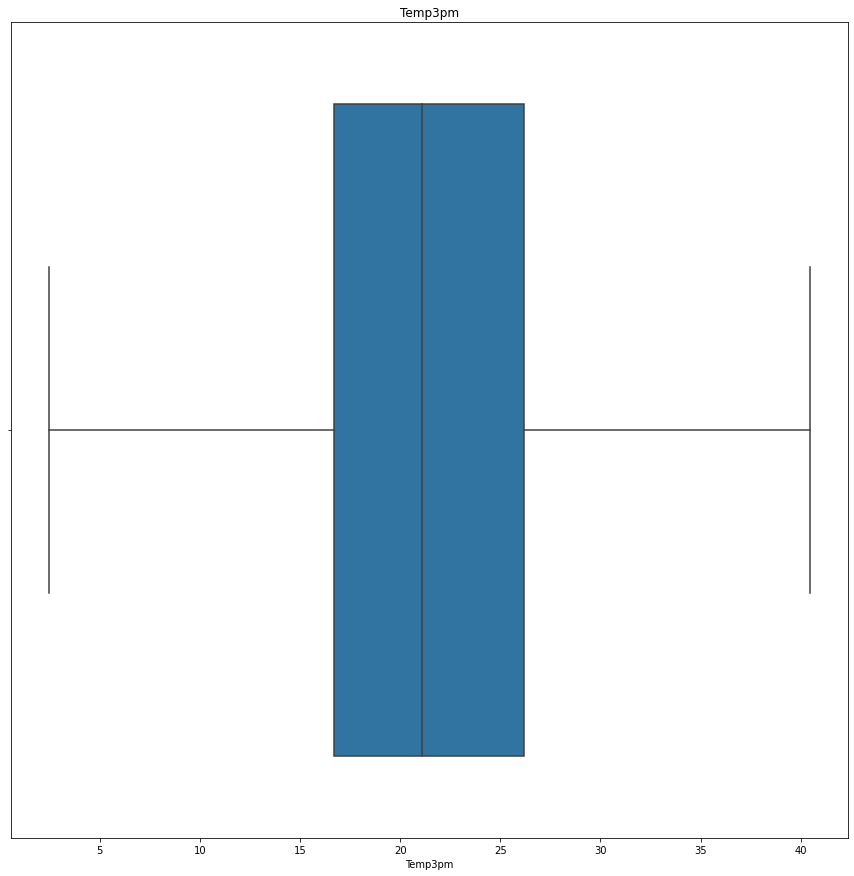

<Figure size 1080x1080 with 0 Axes>

In [65]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [66]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


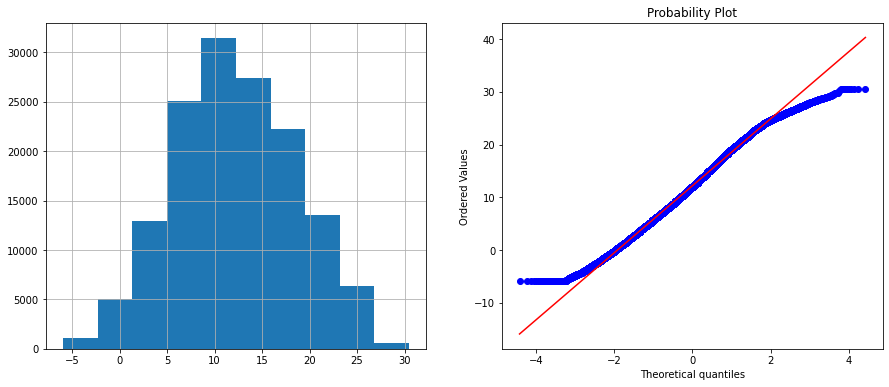

MaxTemp


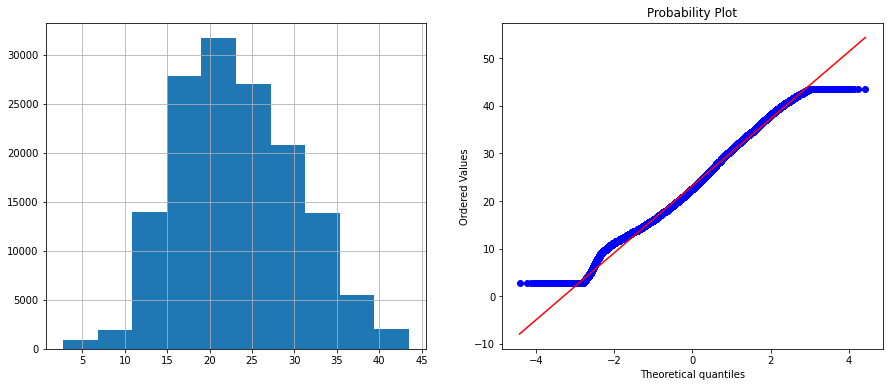

Rainfall


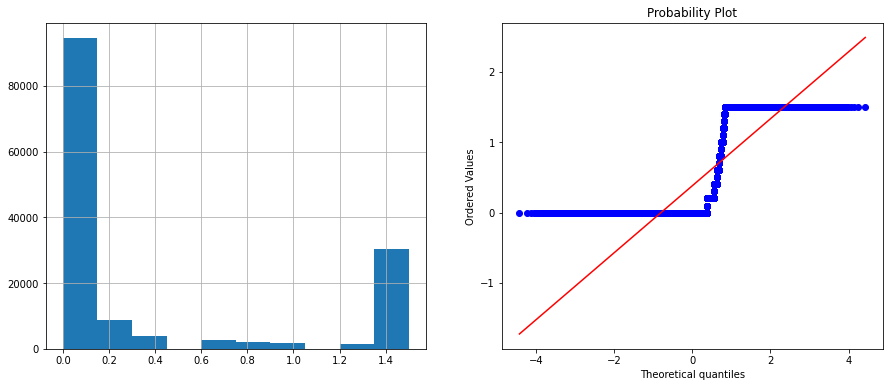

Evaporation


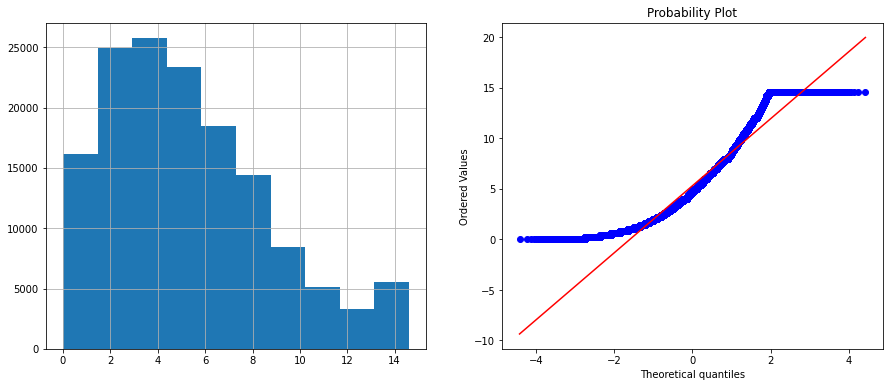

Sunshine


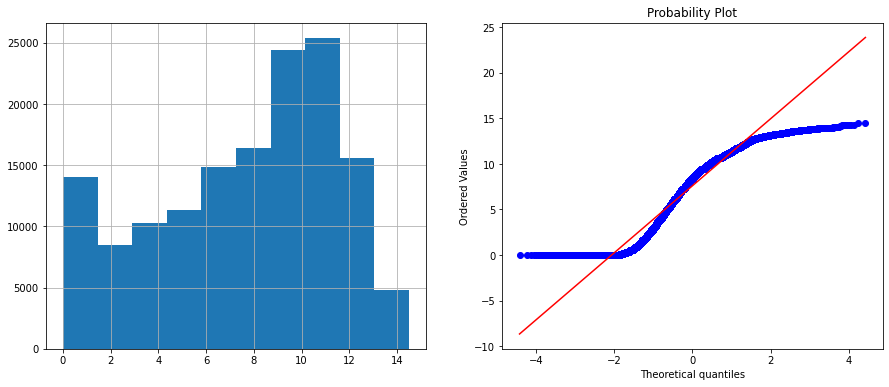

WindGustSpeed


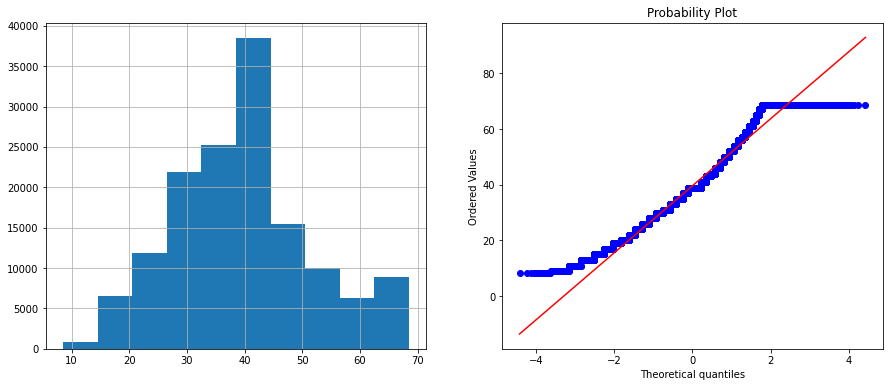

WindSpeed9am


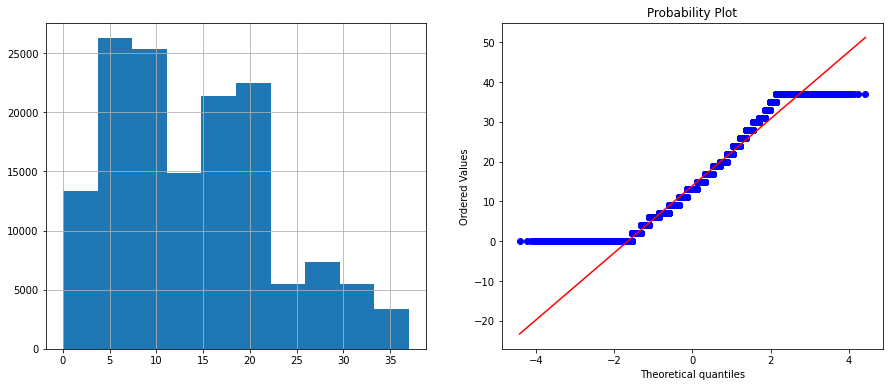

WindSpeed3pm


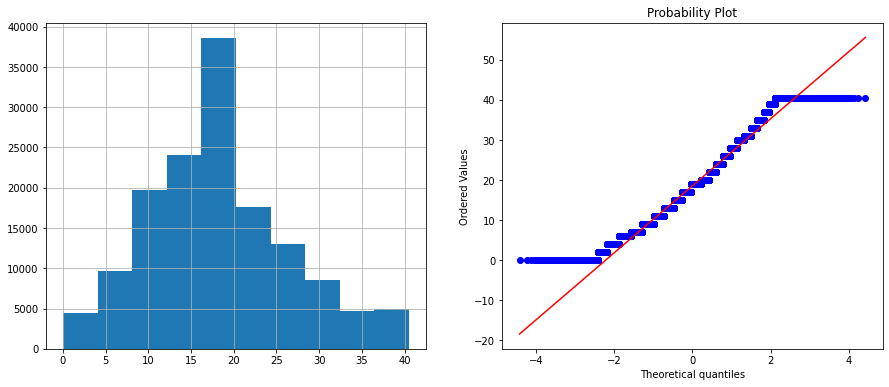

Humidity9am


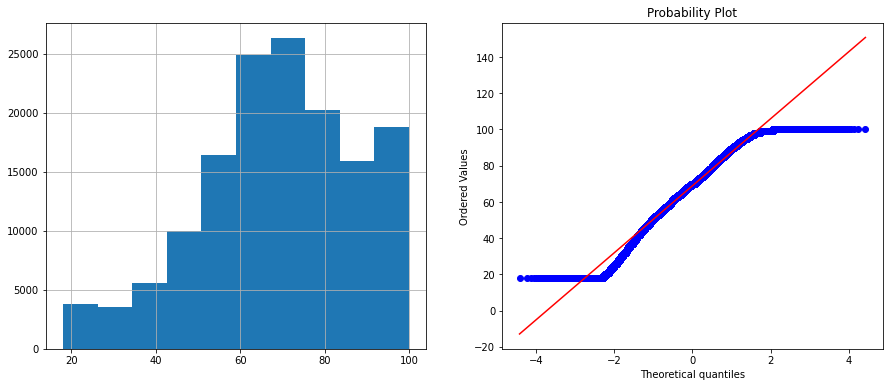

Humidity3pm


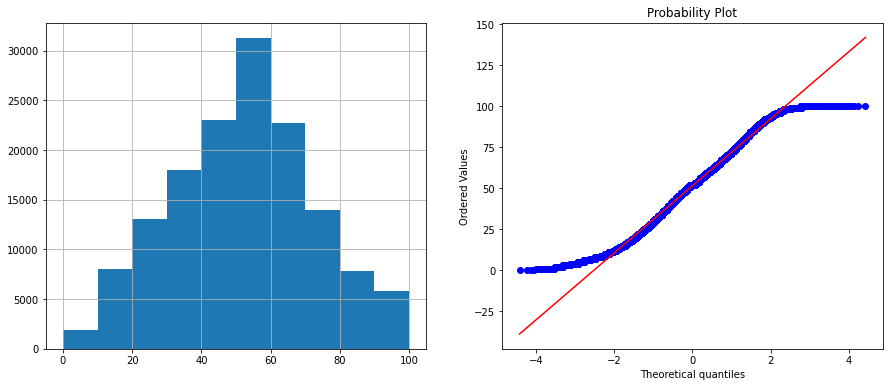

Pressure9am


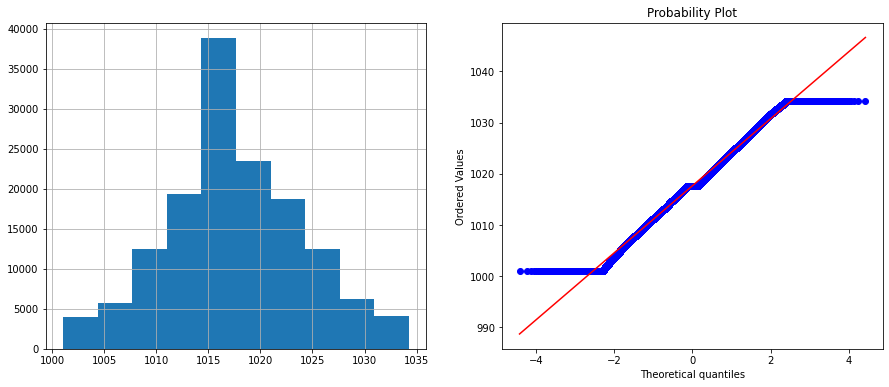

Pressure3pm


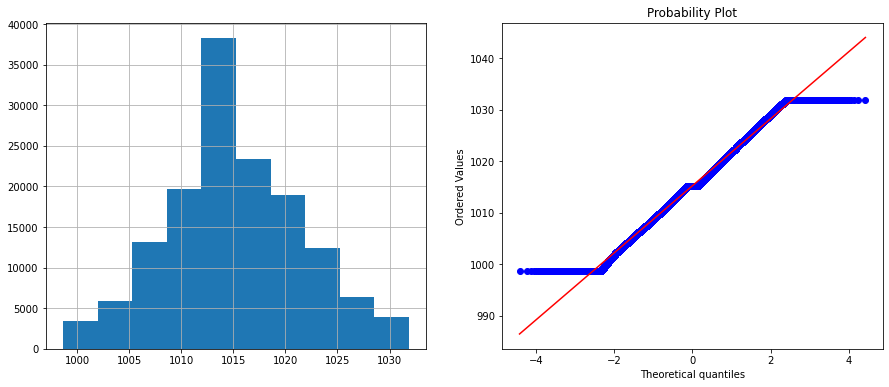

Temp9am


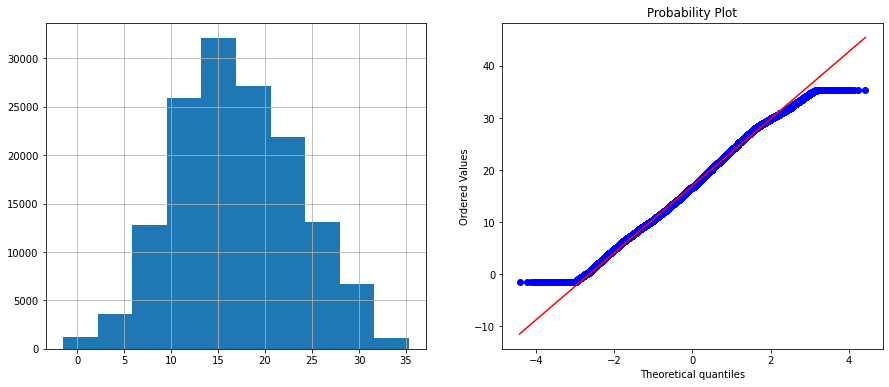

Temp3pm


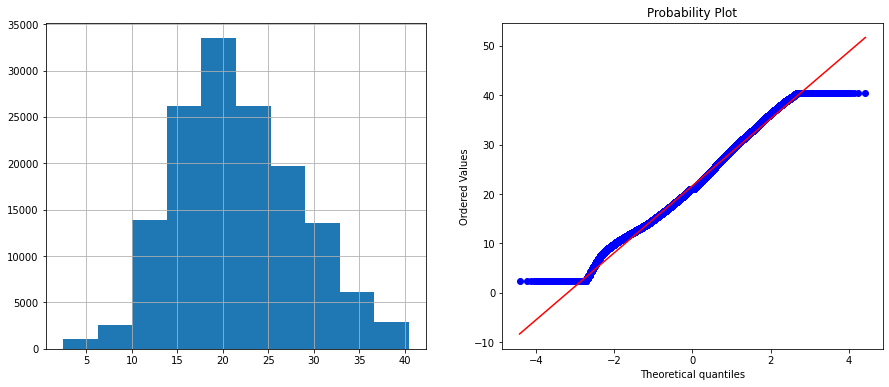

In [67]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [68]:
df.to_csv("preprocessed_1.csv", index=False)

In [69]:
df
df.isnull()
#df["winddir9am"].dropna();

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
145456,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
145457,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
145458,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True


In [70]:

#df.isnull().sum()*100/len(df)
df=df.dropna()
df.isnull().sum()*100/len(df)
X = df.drop(["RainTomorrow"], axis=1)
X.isnull().sum()*100/len(df)
Y = df["RainTomorrow"]

In [71]:
X.isnull().sum()*100/len(X)

X.dropna

<bound method DataFrame.dropna of Empty DataFrame
Columns: [Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, Date_month, Date_day]
Index: []>

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
86389,21.0,12.0,28.4,0.0,5.2,6.4,4.0,31.0,1.0,1.0,4.0,4.0,70.0,56.0,1011.1,1009.2,7.0,7.0,16.7,28.0,0
103676,30.0,15.6,19.8,0.0,6.8,0.0,10.0,54.0,13.0,12.0,30.0,31.0,55.0,54.0,1013.5,1013.4,7.0,8.0,17.1,18.7,0
47239,28.0,-4.2,13.5,0.0,0.8,7.6,7.0,19.0,1.0,7.0,0.0,9.0,90.0,43.0,1027.6,1024.8,1.0,6.0,0.8,12.5,0
104714,30.0,11.1,24.4,0.2,11.4,10.3,12.0,39.0,8.0,12.0,11.0,20.0,60.0,31.0,1015.4,1015.0,7.0,8.0,15.3,23.2,0
120137,33.0,19.0,35.2,0.0,11.8,12.3,9.0,33.0,1.0,6.0,6.0,19.0,53.0,34.0,1013.0,1011.1,0.0,1.0,28.1,33.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112420,1.0,10.9,27.5,0.0,4.2,3.7,10.0,39.0,14.0,12.0,15.0,24.0,67.0,44.0,1017.6,1015.2,6.0,7.0,17.8,25.0,0
84041,21.0,8.3,22.1,0.0,3.2,9.8,11.0,26.0,7.0,11.0,7.0,11.0,75.0,53.0,1021.7,1017.2,1.0,1.0,14.0,20.9,0
9338,10.0,8.1,22.8,0.0,6.0,11.9,7.0,65.0,7.0,8.0,22.0,39.0,36.0,32.0,1014.8,1013.7,2.0,1.0,16.6,22.3,0
55806,15.0,5.4,17.1,0.0,6.4,6.2,12.0,44.0,14.0,10.0,17.0,20.0,72.0,58.0,1023.8,1020.7,3.0,8.0,11.4,15.3,0


In [ ]:
sm=SMOTE(random_state=0)


#print(y_train)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 71128, 1: 20555})
The number of classes after fit Counter({0: 71128, 1: 71128})


In [ ]:
df.["Weather_India.csv"]

In [ ]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.045316
0:	total: 90.9ms	remaining: 3m 1s
1:	total: 115ms	remaining: 1m 55s
2:	total: 152ms	remaining: 1m 41s
3:	total: 177ms	remaining: 1m 28s
4:	total: 216ms	remaining: 1m 26s
5:	total: 266ms	remaining: 1m 28s
6:	total: 316ms	remaining: 1m 29s
7:	total: 360ms	remaining: 1m 29s
8:	total: 406ms	remaining: 1m 29s
9:	total: 461ms	remaining: 1m 31s
10:	total: 506ms	remaining: 1m 31s
11:	total: 548ms	remaining: 1m 30s
12:	total: 602ms	remaining: 1m 32s
13:	total: 654ms	remaining: 1m 32s
14:	total: 701ms	remaining: 1m 32s
15:	total: 756ms	remaining: 1m 33s
16:	total: 810ms	remaining: 1m 34s
17:	total: 869ms	remaining: 1m 35s
18:	total: 920ms	remaining: 1m 35s
19:	total: 979ms	remaining: 1m 36s
20:	total: 1.05s	remaining: 1m 39s
21:	total: 1.1s	remaining: 1m 38s
22:	total: 1.16s	remaining: 1m 39s
23:	total: 1.21s	remaining: 1m 39s
24:	total: 1.26s	remaining: 1m 39s
25:	total: 1.32s	remaining: 1m 40s
26:	total: 1.37s	remaining: 1m 40s
27:	total: 1.4s	remaining: 1m 38s
28

In [ ]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[16825   957]
 [ 2262  2877]]
0.8595611011735963
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17782
           1       0.75      0.56      0.64      5139

    accuracy                           0.86     22921
   macro avg       0.82      0.75      0.78     22921
weighted avg       0.85      0.86      0.85     22921



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7530090379804499

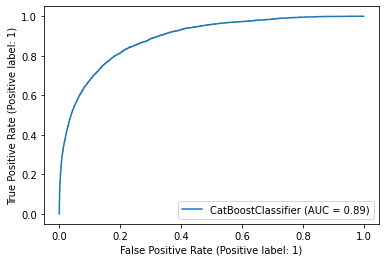

In [ ]:
metrics.plot_roc_curve(cat, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred, average=None) 

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [ ]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[16163  1619]
 [ 2018  3121]]
0.8413245495397234
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     17782
           1       0.66      0.61      0.63      5139

    accuracy                           0.84     22921
   macro avg       0.77      0.76      0.77     22921
weighted avg       0.84      0.84      0.84     22921



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7581347361262647

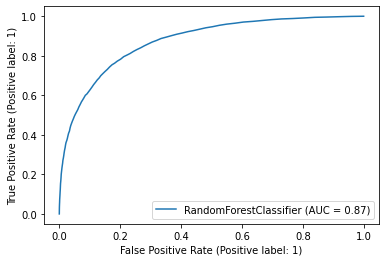

In [ ]:
metrics.plot_roc_curve(rf, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred1, average=None) 

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[17649  5068]
 [ 1519  4856]]
0.7735803657362849
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     22717
           1       0.49      0.76      0.60      6375

    accuracy                           0.77     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.77      0.79     29092



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


NameError: name 'y_pred2' is not defined

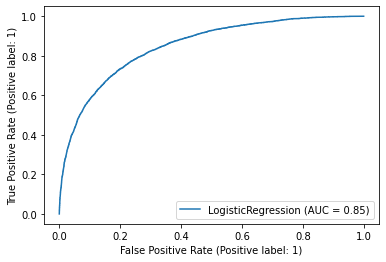

In [ ]:
metrics.plot_roc_curve(logreg, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred2, average=None) 

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [ ]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[13498  4284]
 [ 1375  3764]]
0.7531085031194101
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     17782
           1       0.47      0.73      0.57      5139

    accuracy                           0.75     22921
   macro avg       0.69      0.75      0.70     22921
weighted avg       0.81      0.75      0.77     22921



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7457602177626421

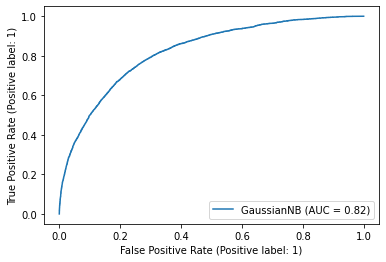

In [ ]:
metrics.plot_roc_curve(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

[[13568  4214]
 [ 1433  3706]]
0.7536320404868897
              precision    recall  f1-score   support

           0       0.90      0.76      0.83     17782
           1       0.47      0.72      0.57      5139

    accuracy                           0.75     22921
   macro avg       0.69      0.74      0.70     22921
weighted avg       0.81      0.75      0.77     22921



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7420853790657294

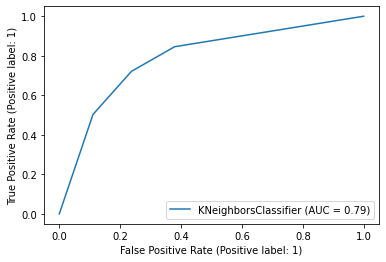

In [ ]:
metrics.plot_roc_curve(knn, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred4, average=None) 

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
y_pred6 = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[16735  1047]
 [ 2286  2853]]
0.85458749618254
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     17782
           1       0.73      0.56      0.63      5139

    accuracy                           0.85     22921
   macro avg       0.81      0.75      0.77     22921
weighted avg       0.85      0.85      0.85     22921



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.748143304362762

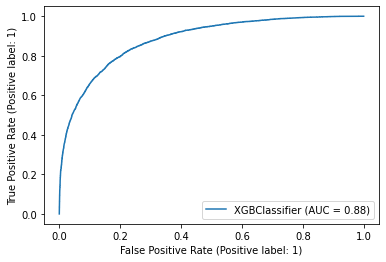

In [ ]:
metrics.plot_roc_curve(xgb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred6, average=None) 

In [ ]:
svc = SVC()
svc.fit(X_train_res, y_train_res)

SVC()

In [ ]:
y_pred5 = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))

[[13999  3783]
 [ 1291  3848]]
0.7786309497840408
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     17782
           1       0.50      0.75      0.60      5139

    accuracy                           0.78     22921
   macro avg       0.71      0.77      0.72     22921
weighted avg       0.82      0.78      0.79     22921



/home/manjunatha/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7680202932976797

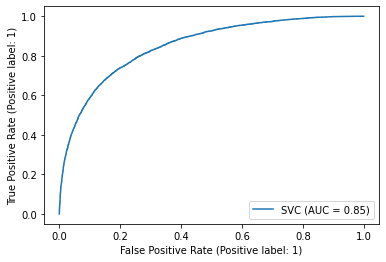

In [ ]:
metrics.plot_roc_curve(svc, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred5, average=None) 

In [ ]:
# joblib.dump(rf, "rf.pkl")
# joblib.dump(cat, "cat.pkl")
# joblib.dump(logreg, "logreg.pkl")
# joblib.dump(gnb, "gnb.pkl")
# joblib.dump(knn, "knn.pkl")
joblib.dump(svc, "svc.pkl")
joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']